In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [6]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, RDKitMinimalLib, GLM, PyPlot, Statistics

import PyPlot; const plt = PyPlot;
include("../saftvrmienn.jl");
include("plotting_functions.jl");
# workspace()

In [3]:
vr_mie_source_params = CSV.read("../saftvrmie_params/saft_vr_mie_validation_data.csv", DataFrame, header=1);
pcp_source_params = CSV.read("../pcpsaft_params/training_data.csv", DataFrame, header=1);

In [4]:
processed_data = process_raw_params("../jobs/23_updated_Clapeyron/5_clip_points_strat2/params_log.csv", pcp_source_params);

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578


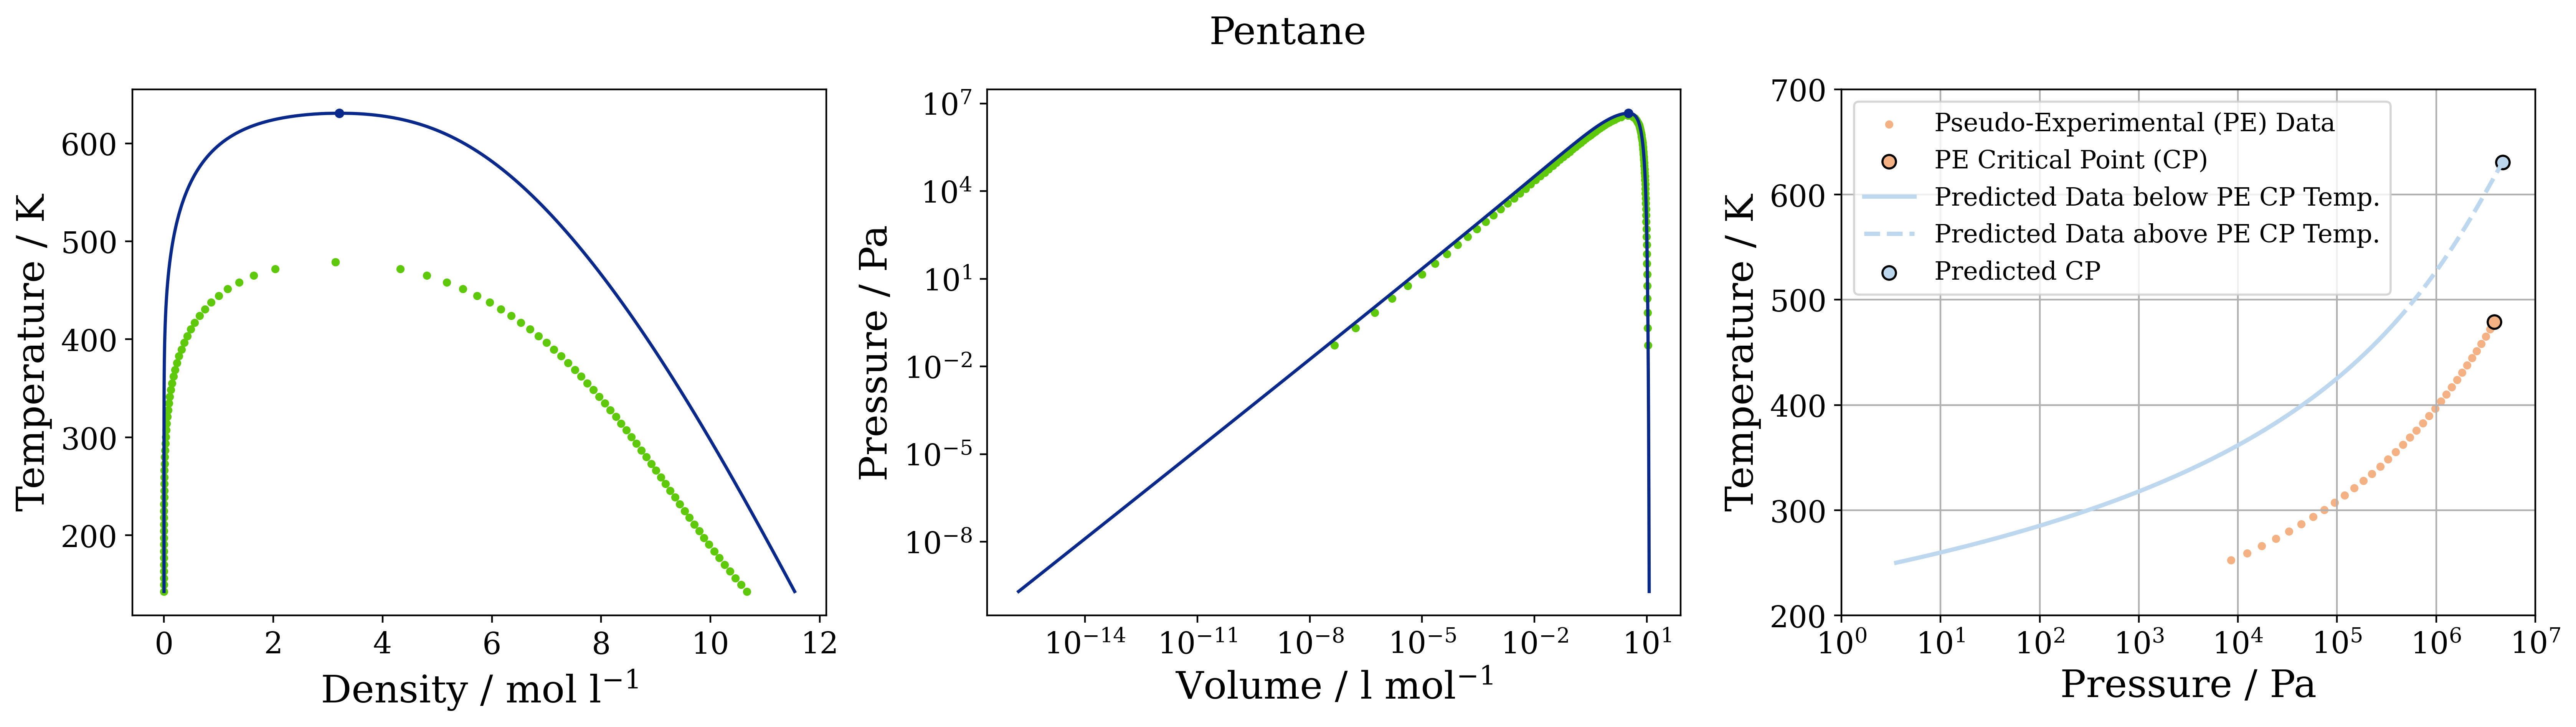

In [37]:
# Plot source pcp saft and saft-vr mie regressed parameter phase envelope (over given temperature range)

test_species = "Pentane"
# test_species = "2,2,4,4,6,8,8-heptamethylnonane"

# set plotting properties
plot_all_exptl_data = true
second_deriv_props_p = 10^5
n_points_exptl = 50
same_temp_range = false
plot_dashed_above_crit = false
epoch = 1#length(processed_data[1,:m])
label_fontsize = 18
ticks_fontsize = 14
T_min_plot = 250

source_data_test_species = filter(row -> row.common_name == lowercase(test_species), pcp_source_params);
processed_data_split = processed_data #filter(row -> row.split == "val", processed_data)

# obtain plotting data
T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(test_species), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p,n_points=n_points_exptl, same_temp_range=same_temp_range)
T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(test_species), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

v_liq_range_pcp, v_liq_range_vrmie = remove_nans(v_liq_range_pcp, v_liq_range_vrmie)
v_vap_range_pcp, v_vap_range_vrmie = remove_nans(v_vap_range_pcp, v_vap_range_vrmie)
p_range_pcp, p_range_vrmie = remove_nans(p_range_pcp, p_range_vrmie)
cp_range_pcp, cp_range_vrmie = remove_nans(cp_range_pcp, cp_range_vrmie)

if plot_all_exptl_data == true
    pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
    pcp_rho_plot = 1e-3 ./pcp_v_plot
    pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
    pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
    pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
    pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
else
    pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
    pcp_rho_plot = 1e-3 ./pcp_v_plot
    pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
    pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
    pcp_T_plot_cc = T_range_pcp
    pcp_P_plot_cc = p_range_pcp
end

vrmie_rho_plot = 1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie))
vrmie_T_plot = vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie))
vrmie_P_plot = vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie))
vrmie_rho_plot_liq = 1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3])
vrmie_rho_plot_vap = 1e-3 ./v_vap_range_vrmie



figure_1, axes_1 = plt.subplots(1,3, figsize=(17, 5), dpi=400)
figure_1.suptitle(test_species, fontsize=18,y=0.95)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=ticks_fontsize)

# Axes 1
axes_1[1].scatter(pcp_rho_plot, pcp_T_plot_envelope, color="#5dc90a",s=8)
axes_1[1].scatter(1e-3/vrmie_crits[3], vrmie_crits[1], color="#08298a",s=12)

if plot_dashed_above_crit == true
    
    index_cutoff_crit = argmin(abs.(T_range_vrmie .- pcp_crits[1]))
    
    axes_1[1].plot(vrmie_rho_plot_liq[1:index_cutoff-1], vcat(T_range_vrmie, vrmie_crits[1])[1:index_cutoff-1],color="#08298a")
    axes_1[1].plot(vrmie_rho_plot_liq[index_cutoff:end], vcat(T_range_vrmie, vrmie_crits[1])[index_cutoff:end],color="#08298a","--")

    axes_1[1].plot(vrmie_rho_plot_vap[1:index_cutoff-1], T_range_vrmie[1:index_cutoff-1],color="#08298a")
    axes_1[1].plot(vrmie_rho_plot_vap[index_cutoff:end], T_range_vrmie[index_cutoff:end],color="#08298a","--")

else

    axes_1[1].plot(vrmie_rho_plot, vrmie_T_plot,color="#08298a")

end

axes_1[2].scatter(pcp_rho_plot, pcp_P_plot_envelope, color="#5dc90a",s=8)
axes_1[2].scatter(1e-3 /vrmie_crits[3], vrmie_crits[2], color="#08298a",s=12)
axes_1[2].loglog(vrmie_rho_plot, vrmie_P_plot ,color="#08298a")

index_cutoff_crit = argmin(abs.(T_range_vrmie .- pcp_crits[1]))
index_cutoff_T_min_vrmie = argmin(abs.(T_range_vrmie .- T_min_plot))
index_cutoff_T_min_pcp = argmin(abs.(pcp_T_plot_cc .- T_min_plot))

# axes_1[3].axhline(0.95*pcp_crits[1], color="black", linestyle="--", label="Horizontal Line")
axes_1[3].scatter(pcp_P_plot_cc[index_cutoff_T_min_pcp:end], pcp_T_plot_cc[index_cutoff_T_min_pcp:end], color="#F4B183",s=8)
axes_1[3].scatter(pcp_crits[2], pcp_crits[1], color="#F4B183",s=40,edgecolors="black")

axes_1[3].plot(p_range_vrmie[index_cutoff_T_min_vrmie:index_cutoff_crit-1], T_range_vrmie[index_cutoff_T_min_vrmie:index_cutoff_crit-1], color="#BDD7EE",linewidth=2)
axes_1[3].plot(p_range_vrmie[index_cutoff_crit:end], T_range_vrmie[index_cutoff_crit:end], color="#BDD7EE",linewidth=2,"--")
axes_1[3].scatter(vrmie_crits[2], vrmie_crits[1], color="#BDD7EE",s=40,edgecolors="black")


# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2],ticks_fontsize = 14)
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[1].set_ylim([150,400])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[1].set_xlabel(L"Density / mol l$\mathregular{^{-1}}$",fontsize=label_fontsize)
axes_1[1].set_ylabel("Temperature / K",fontsize=label_fontsize)

# axes_1[1].set_xticks([10^-3, 10^-2, 10^-1, 10^0, 10^1, 10^2])
# axes_1[1].set_yticks(range(150,400,6))
# axes_1[2].set_ylim([10^-10,10^12])
# axes_1[1].set_xlim([10^-3,10^2])
axes_1[2].set_xlabel(L"Volume / l mol$\mathregular{^{-1}}$",fontsize=label_fontsize)
axes_1[2].set_ylabel("Pressure / Pa",fontsize=label_fontsize)
# axes_1[2].legend(["Pseudo-Experimental Data","Predicted Critical Point","Predicted Point"],loc="upper left")


axes_1[3].set_xscale("log")
# axes_1[2].set_xtickslabel(e)
axes_1[3].set_xticks([10^0, 10^1, 10^2, 10^3, 10^4, 10^5, 10^6, 10^7])
axes_1[3].set_xlim([10^0,10^7])
axes_1[3].set_ylim([200,700])
axes_1[3].set_ylabel("Temperature / K",fontsize=label_fontsize)
axes_1[3].set_xlabel("Pressure / Pa",fontsize=label_fontsize)
axes_1[3].grid("on")
axes_1[3].legend(["Pseudo-Experimental (PE) Data","PE Critical Point (CP)","Predicted Data below PE CP Temp.","Predicted Data above PE CP Temp.","Predicted CP"],fontsize=11.75)
# axes_1[3].legend(["0.95 Pseudo-Experimental Critical Point"],fontsize=12, loc="upper left")


tight_layout()

In [9]:
files_for_val = [
    "../jobs/23_updated_Clapeyron/5_clip_points_strat1/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat2/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat3/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat4/params_log.csv",
    "../jobs/23_updated_Clapeyron/5_clip_points_strat5/params_log.csv"
];

# files_for_val = [
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat1/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat2/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat3/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat4/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_ignore_points_strat5/params_log.csv"
# ];

# files_for_val = [
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat1/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat2/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat3/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat4/params_log.csv",
#     "../jobs/23_updated_Clapeyron/5_Tr_Tc_atom_pair_strat5/params_log.csv"
# ];

In [10]:
string_arrays_dict = Dict{Int, Vector{String}}()
processed_data_storage = []

keys_string_dict = 1:length(files_for_val)

for (key, path) in zip(keys_string_dict,files_for_val)
        
        processed_data = process_raw_params(path, pcp_source_params)

        processed_data_split = filter(row -> row.split == "val", processed_data)

        push!(processed_data_storage, processed_data_split)

        string_arrays_dict[key] = processed_data_split.species

end

┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV ~/.julia/packages/CSV/OnldF/src/file.jl:578
┌ Warning: thread = 1 warning: parsed expected 8 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ 

Hexane
2,2,4,4,6,8,8-Heptamethylnonane
Squalane
2-Methylbutane
2,3-Dimethylundecane
2,2,3,4-Tetramethylpentane


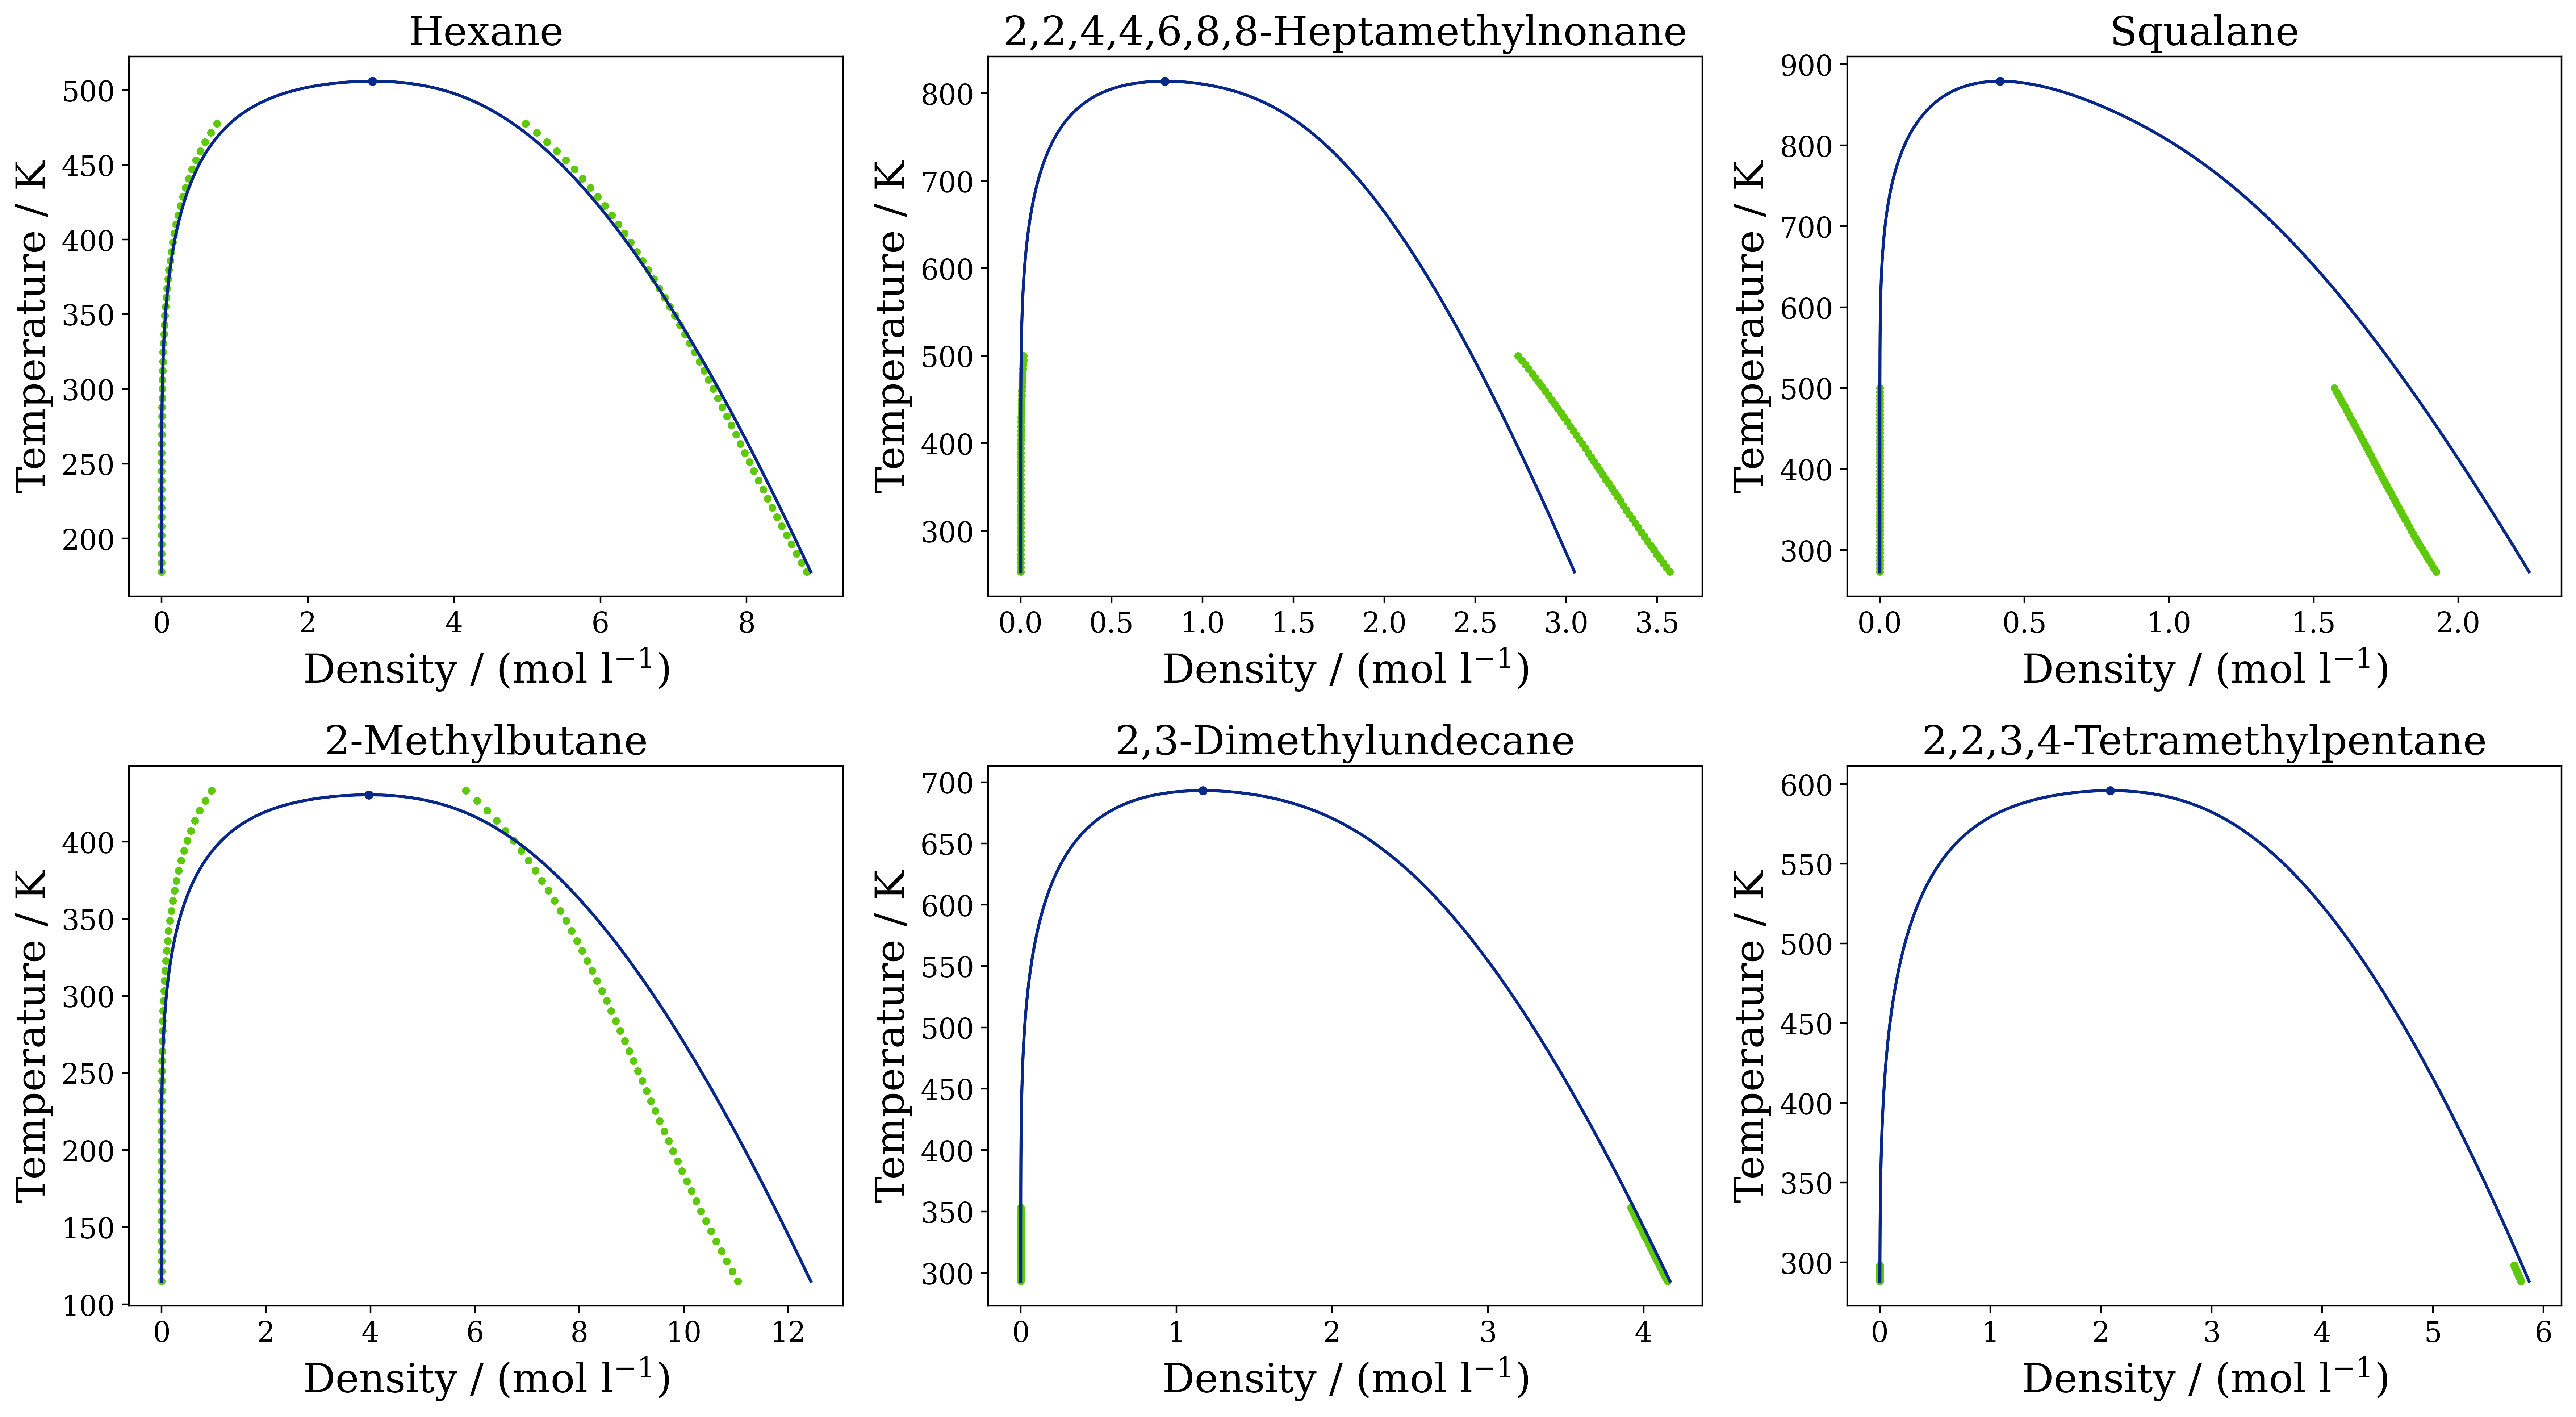

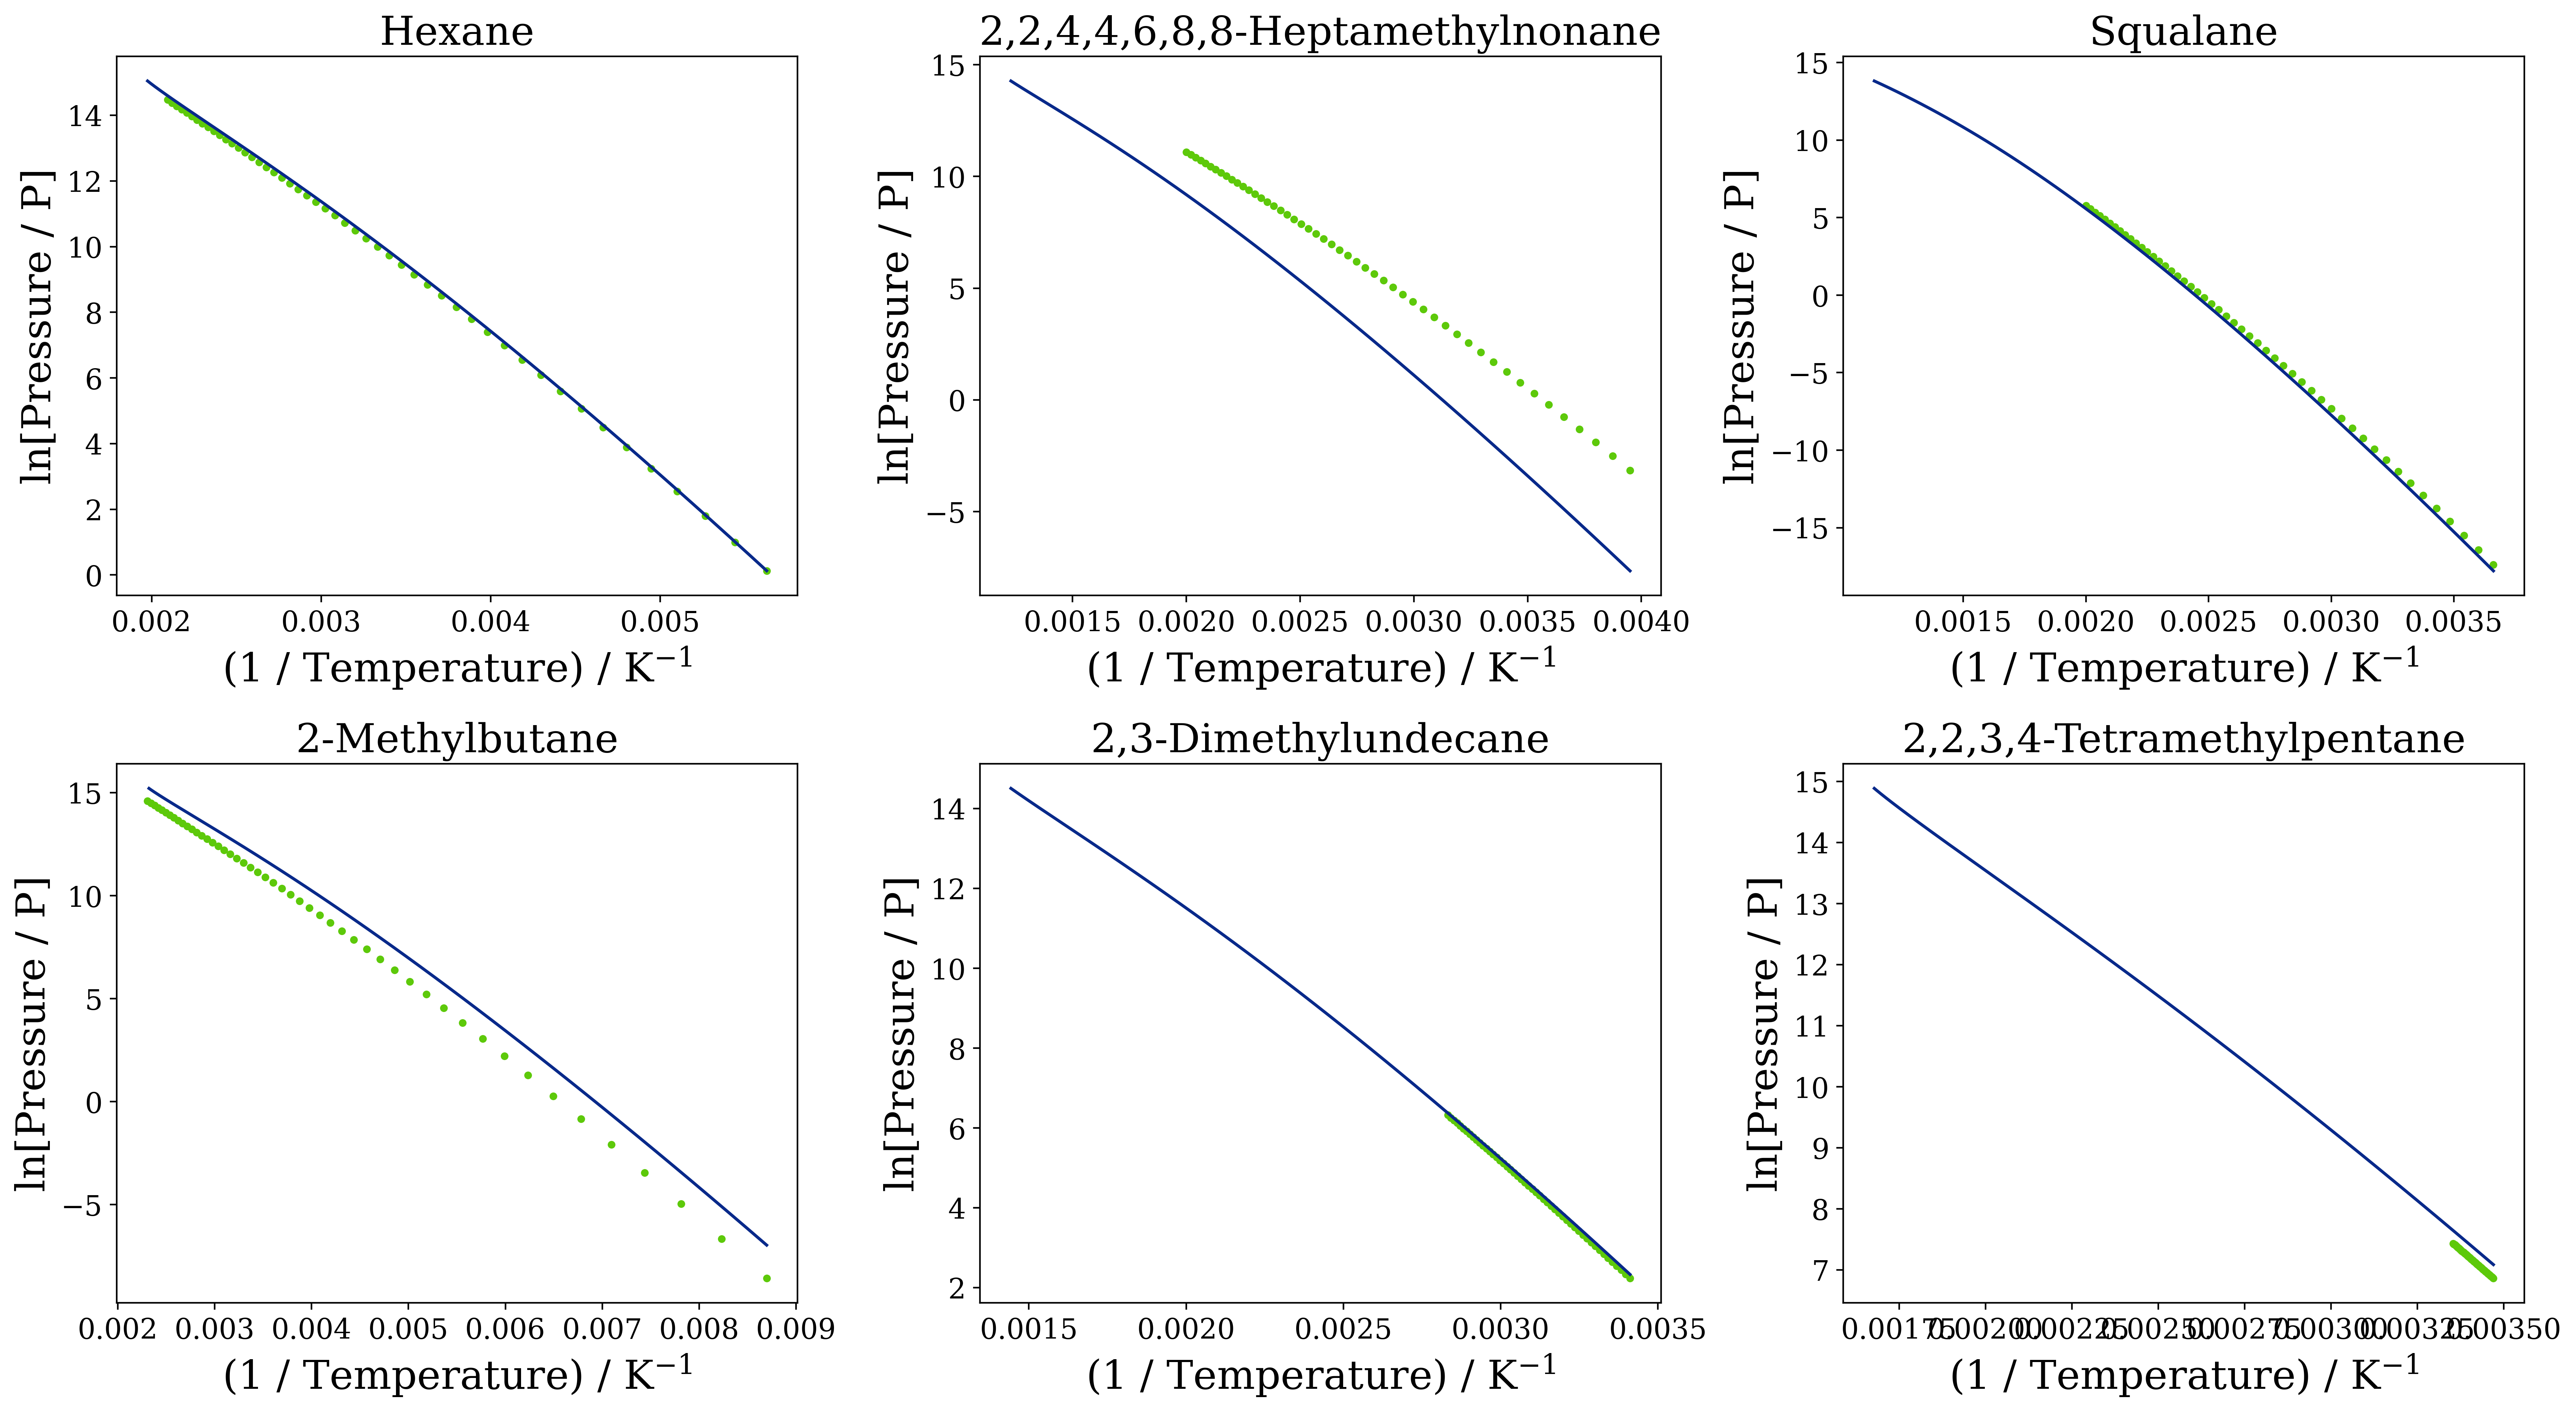

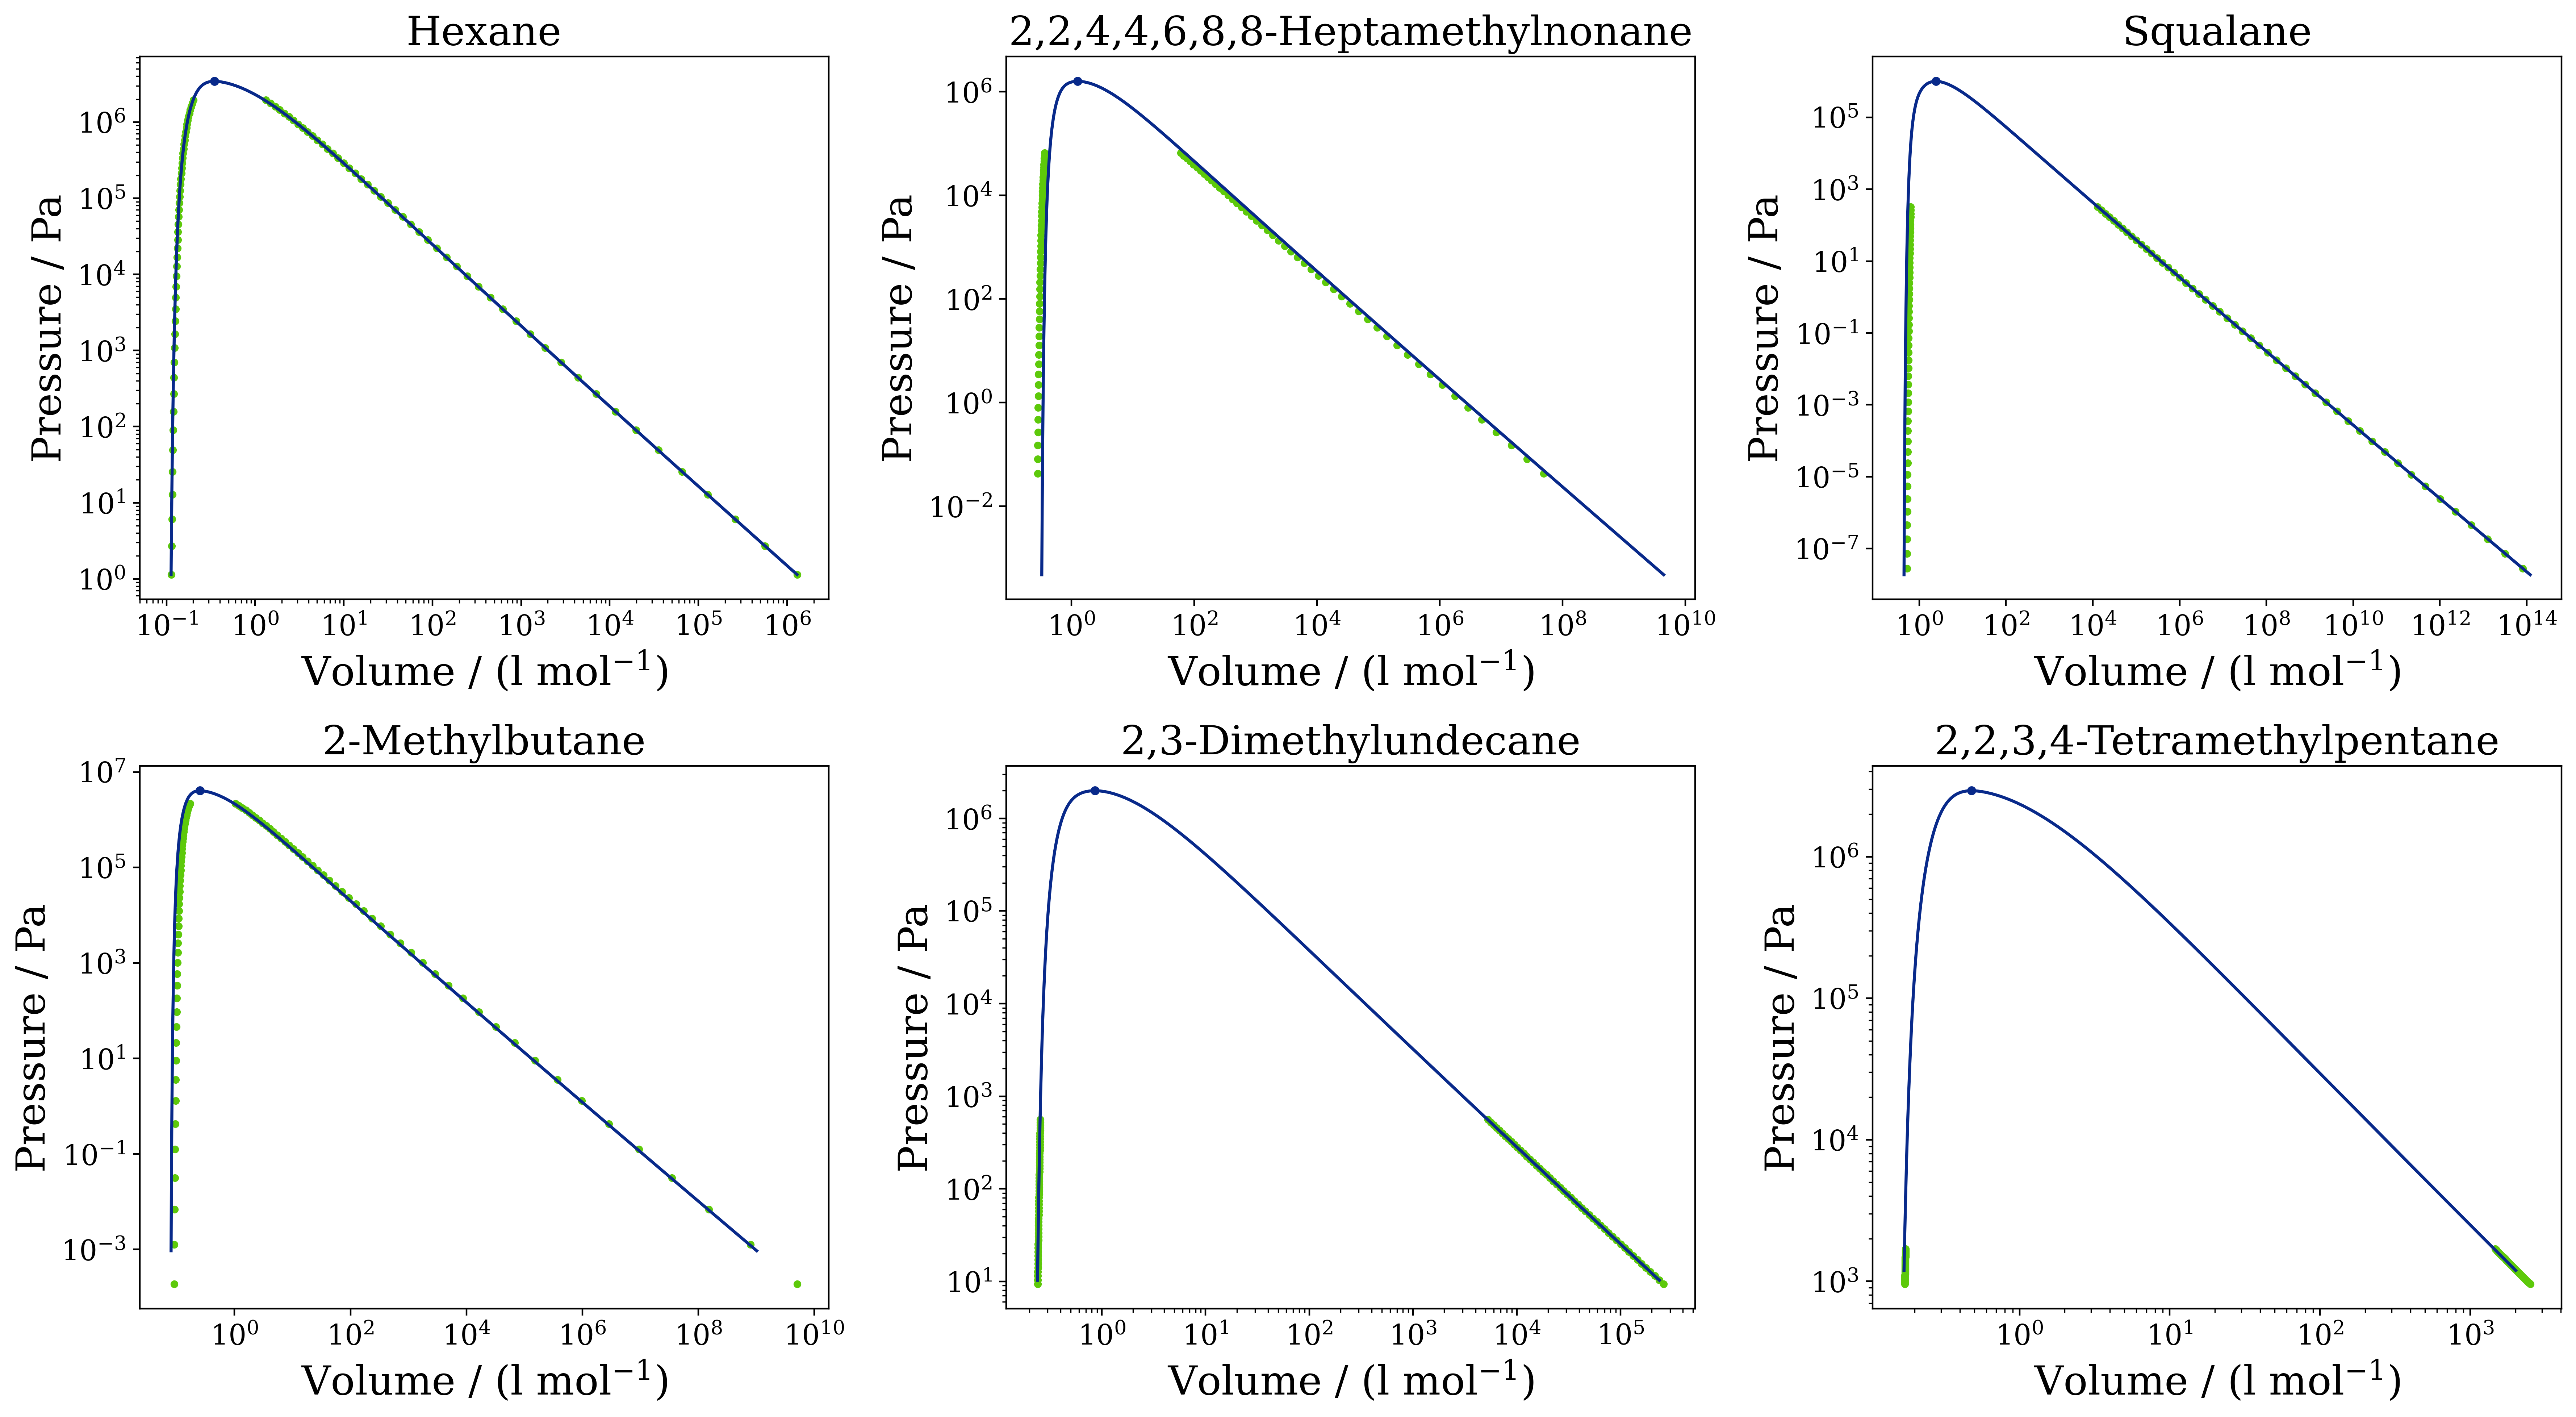

In [58]:
# Plot saturation data for validation set for these species
species = ["Hexane","2,2,4,4,6,8,8-Heptamethylnonane","Squalane","2-Methylbutane","2,3-Dimethylundecane","2,2,3,4-Tetramethylpentane"]

fontsize_label_title = 20
fontsize_ticks = 16

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif", size=14)

# Specify the range and spacing of experimental data to be plotted
plot_all_exptl_data = false
n_points_exptl = 50
same_temp_range = false

# Computed data properties
second_deriv_props_p = 10^5

# Specify vrmie epoch to plot
epoch = length(processed_data_storage[1][!,:m][1])

# Plot line colours
colours = ["#5dc90a","#08298a"] # Experimental, Predicted

figure1, axes_fig_1 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure1.suptitle("Temperature-Density Phase Envelopes", fontsize=24,y=0.95)

figure2, axes_fig_2 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure2.suptitle("Clausius-Clapeyron", fontsize=24,y=0.95)

figure3, axes_fig_3 = plt.subplots(2, 3, figsize=(18, 10), dpi=400)
# figure3.suptitle("Pressure-Volume Phase Evnvelopes", fontsize=24,y=0.95)

for i = 1:length(species)

    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species[i]))
    processed_data_split = processed_data_storage[key_i]

    source_data_test_species = filter(row -> row.common_name == lowercase(species[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(species[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(species[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)

    if i < 4
        k = 1
        j = i
    else
        k = 2
        j = i - 3
    end

    println(species[i])

    if plot_all_exptl_data == true
        pcp_v_plot = vcat(v_liq_range_pcp, pcp_crits[3], v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, pcp_crits[1], T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, pcp_crits[2], p_range_pcp)
        pcp_T_plot_cc = vcat(T_range_pcp, pcp_crits[1])
        pcp_P_plot_cc = vcat(p_range_pcp, pcp_crits[2])
    else
        pcp_v_plot = vcat(v_liq_range_pcp, v_vap_range_pcp)
        pcp_rho_plot = 1e-3 ./pcp_v_plot
        pcp_T_plot_envelope = vcat(T_range_pcp, T_range_pcp)
        pcp_P_plot_envelope = vcat(p_range_pcp, p_range_pcp)
        pcp_T_plot_cc = T_range_pcp
        pcp_P_plot_cc = p_range_pcp
    end

    axes_fig_1[k, j].scatter(pcp_rho_plot, pcp_T_plot_envelope, color="#5dc90a",s=8)
    axes_fig_1[k, j].scatter(1e-3 /vrmie_crits[3], vrmie_crits[1], color="#08298a",s=12)
    axes_fig_1[k, j].plot(1e-3 ./vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)), vcat(T_range_vrmie, vrmie_crits[1], reverse(T_range_vrmie)),color="#08298a")

    axes_fig_1[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_xlabel(L"Density / (mol l$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_1[k, j].set_ylabel("Temperature / K",fontsize=fontsize_label_title)

    axes_fig_2[k, j].scatter(1 ./pcp_T_plot_cc, log.(pcp_P_plot_cc),color="#5dc90a",s=8)
    axes_fig_2[k, j].plot(1 ./T_range_vrmie, log.(p_range_vrmie),color="#08298a")

    axes_fig_2[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_xlabel(L"(1 / Temperature) / K$\mathregular{^{-1}}$",fontsize=fontsize_label_title)
    axes_fig_2[k, j].set_ylabel("ln[Pressure / P]",fontsize=fontsize_label_title)

    axes_fig_3[k, j].scatter(pcp_v_plot ./ 1e-3, pcp_P_plot_envelope, color="#5dc90a",s=8)
    axes_fig_3[k, j].scatter(vrmie_crits[3]  / 1e-3, vrmie_crits[2], color="#08298a",s=12)
    axes_fig_3[k, j].loglog(vcat(v_liq_range_vrmie, vrmie_crits[3], reverse(v_vap_range_vrmie)) ./ 1e-3, vcat(p_range_vrmie, vrmie_crits[2], reverse(p_range_vrmie)),color="#08298a")

    axes_fig_3[k, j].set_title(species[i],fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_xlabel(L"Volume / (l mol$\mathregular{^{-1}}$)",fontsize=fontsize_label_title)
    axes_fig_3[k, j].set_ylabel("Pressure / Pa",fontsize=fontsize_label_title)

end
          
figure1.tight_layout()
figure2.tight_layout()
figure3.tight_layout()


# Useful property setting
# axes_fig_1[k, j].set_xscale("log")
# axes_fig_1[k, j].set_xticks(xticks_pe[i])
# axes_fig_1[k, j].set_xlim([xticks_pe[i][1],xticks_pe[i][end]])
# axes_fig_1[k, j].set_yticks(yticks_pe[i])
# axes_fig_1[k, j].set_ylim([yticks_pe[i][1],yticks_pe[i][end]])


In [61]:
species_list = string.(vcat(collect(processed_data_storage[i][!,:species] for i = 1:5)...))

n_points = 50

# Specify the range of experimental data to be plotted
plot_all_exptl_data = false
same_temp_range = true

# Computed data properties
isobaric_heat_capacity_p = 10^5

epoch = length(processed_data_storage[1][!,:m][1])

num_rows = length(species_list)

val_data_summary_APD = DataFrame(
    common_name = fill("", num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    APD_vsat_l = fill(0.0, num_rows),
    APD_vsat_v = fill(0.0, num_rows),
    APD_psat = fill(0.0, num_rows),
    APD_cp = fill(0.0, num_rows),
) ;

val_data_summary_AAD = DataFrame(
    common_name = fill("", num_rows),
    isomeric_SMILES = fill("", num_rows),
    Mw = fill(0.0, num_rows),
    AAD_vsat_l = fill(0.0, num_rows),
    AAD_vsat_v = fill(0.0, num_rows),
    AAD_psat = fill(0.0, num_rows),
    AAD_cp = fill(0.0, num_rows),
) ;

row_counter_data_gen = 1

for i = 1:length(species_list)

    println(species_list[i])

    # find species i data
    key_i = find_key(string_arrays_dict, lowercase(species_list[i]))
    processed_data_split = processed_data_storage[key_i]

    source_data_test_species = filter(row -> row.common_name == lowercase(species_list[i]), pcp_source_params);

    T_range_pcp, pcp_crits, v_liq_range_pcp, v_vap_range_pcp, p_range_pcp, cp_range_pcp = sat_props_calc_PCP(species=lowercase(species_list[i]), source_data_test_species=source_data_test_species, plot_all_exptl_data=plot_all_exptl_data, second_deriv_props_p=second_deriv_props_p,n_points=n_points, same_temp_range=same_temp_range)
    T_range_vrmie, vrmie_crits, v_liq_range_vrmie, v_vap_range_vrmie, p_range_vrmie, cp_range_vrmie = sat_props_calc_VrMie(species=lowercase(species_list[i]), pcp_source_params_split=source_data_test_species, processed_data_split=processed_data_split, plot_all_exptl_data=plot_all_exptl_data, n_points=n_points, epoch=epoch, second_deriv_props_p=second_deriv_props_p, same_temp_range=same_temp_range)


    v_liq_range_pcp, v_liq_range_vrmie = remove_nans(v_liq_range_pcp, v_liq_range_vrmie)
    v_vap_range_pcp, v_vap_range_vrmie = remove_nans(v_vap_range_pcp, v_vap_range_vrmie)
    p_range_pcp, p_range_vrmie = remove_nans(p_range_pcp, p_range_vrmie)
    cp_range_pcp, cp_range_vrmie = remove_nans(cp_range_pcp, cp_range_vrmie)

    v_sat_l_APD = average_percentage_deviation(v_liq_range_vrmie, v_liq_range_pcp)
    v_sat_v_APD = average_percentage_deviation(v_vap_range_vrmie, v_vap_range_pcp)
    p_sat_APD = average_percentage_deviation(p_range_vrmie, p_range_pcp)
    cp_sat_APD = average_percentage_deviation(cp_range_vrmie, cp_range_pcp)

    v_sat_l_AAD = average_absolute_deviation(v_liq_range_vrmie, v_liq_range_pcp)
    v_sat_v_AAD = average_absolute_deviation(v_vap_range_vrmie, v_vap_range_pcp)
    p_sat_AAD = average_absolute_deviation(p_range_vrmie, p_range_pcp)
    cp_sat_AAD = average_absolute_deviation(cp_range_vrmie, cp_range_pcp)

    processed_data_test_species = filter(row -> row.species == lowercase(species_list[i]), processed_data_split);

    val_data_summary_APD[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
    val_data_summary_APD[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
    val_data_summary_APD[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
    val_data_summary_APD[row_counter_data_gen,:APD_vsat_l] = v_sat_l_APD
    val_data_summary_APD[row_counter_data_gen,:APD_vsat_v] = v_sat_v_APD
    val_data_summary_APD[row_counter_data_gen,:APD_psat] = p_sat_APD
    val_data_summary_APD[row_counter_data_gen,:APD_cp] = cp_sat_APD

    val_data_summary_AAD[row_counter_data_gen,:common_name] = processed_data_test_species.species[1]
    val_data_summary_AAD[row_counter_data_gen,:isomeric_SMILES] = processed_data_test_species.isomeric_SMILES[1]
    val_data_summary_AAD[row_counter_data_gen,:Mw] = processed_data_test_species.Mw[1]
    val_data_summary_AAD[row_counter_data_gen,:AAD_vsat_l] = v_sat_l_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_vsat_v] = v_sat_v_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_psat] = p_sat_AAD
    val_data_summary_AAD[row_counter_data_gen,:AAD_cp] = cp_sat_AAD

    row_counter_data_gen += 1
            
end

val_data_summary_APD = sort(val_data_summary_APD, :Mw);
val_data_summary_AAD = sort(val_data_summary_AAD, :Mw);

methane
2-methylbutane
2-methylpentane
2,2,3-trimethylbutane
heptane
3,4-dimethylhexane
3-methyl-3-ethylpentane
2,2,4-trimethylpentane
2,4,4-trimethylhexane
2,3,3,4-tetramethylpentane
decane
2-methyldecane
dodecane
3-methyltridecane
hexadecane
eicosane
ethane
2,2-dimethylpropane
2,2-dimethylbutane
2,3-dimethylpentane
2,4-dimethylpentane
3-methylheptane
2-methyl-3-ethyl-pentane
2,4-dimethylhexane
2,2,3,4-tetramethylpentane
2,2,5-trimethylhexane
2,6-dimethyloctane
2,3-dimethylnonane
3-methyldodecane
2,3-dimethyldodecane
2,2,4,4,6,8,8-heptamethylnonane
tetracosane
propane
pentane
2,3-dimethylbutane
3-methylhexane
2,5-dimethylhexane
2,2,3-trimethylpentane
2,3,3-trimethylpentane
4-methylheptane
3,3-diethylpentane
2,3-dimethylheptane
2,7-dimethyloctane
3-methylundecane
tridecane
tetradecane
heptadecane
heptacosane
n-butane
3-methylpentane
3-ethylpentane
3,3-dimethylpentane
2-methylheptane
octane
3-ethylhexane
2,3-dimethylhexane
2-methyloctane
2,2,3,3-tetramethylpentane
3-methyldecane
2,3-dim

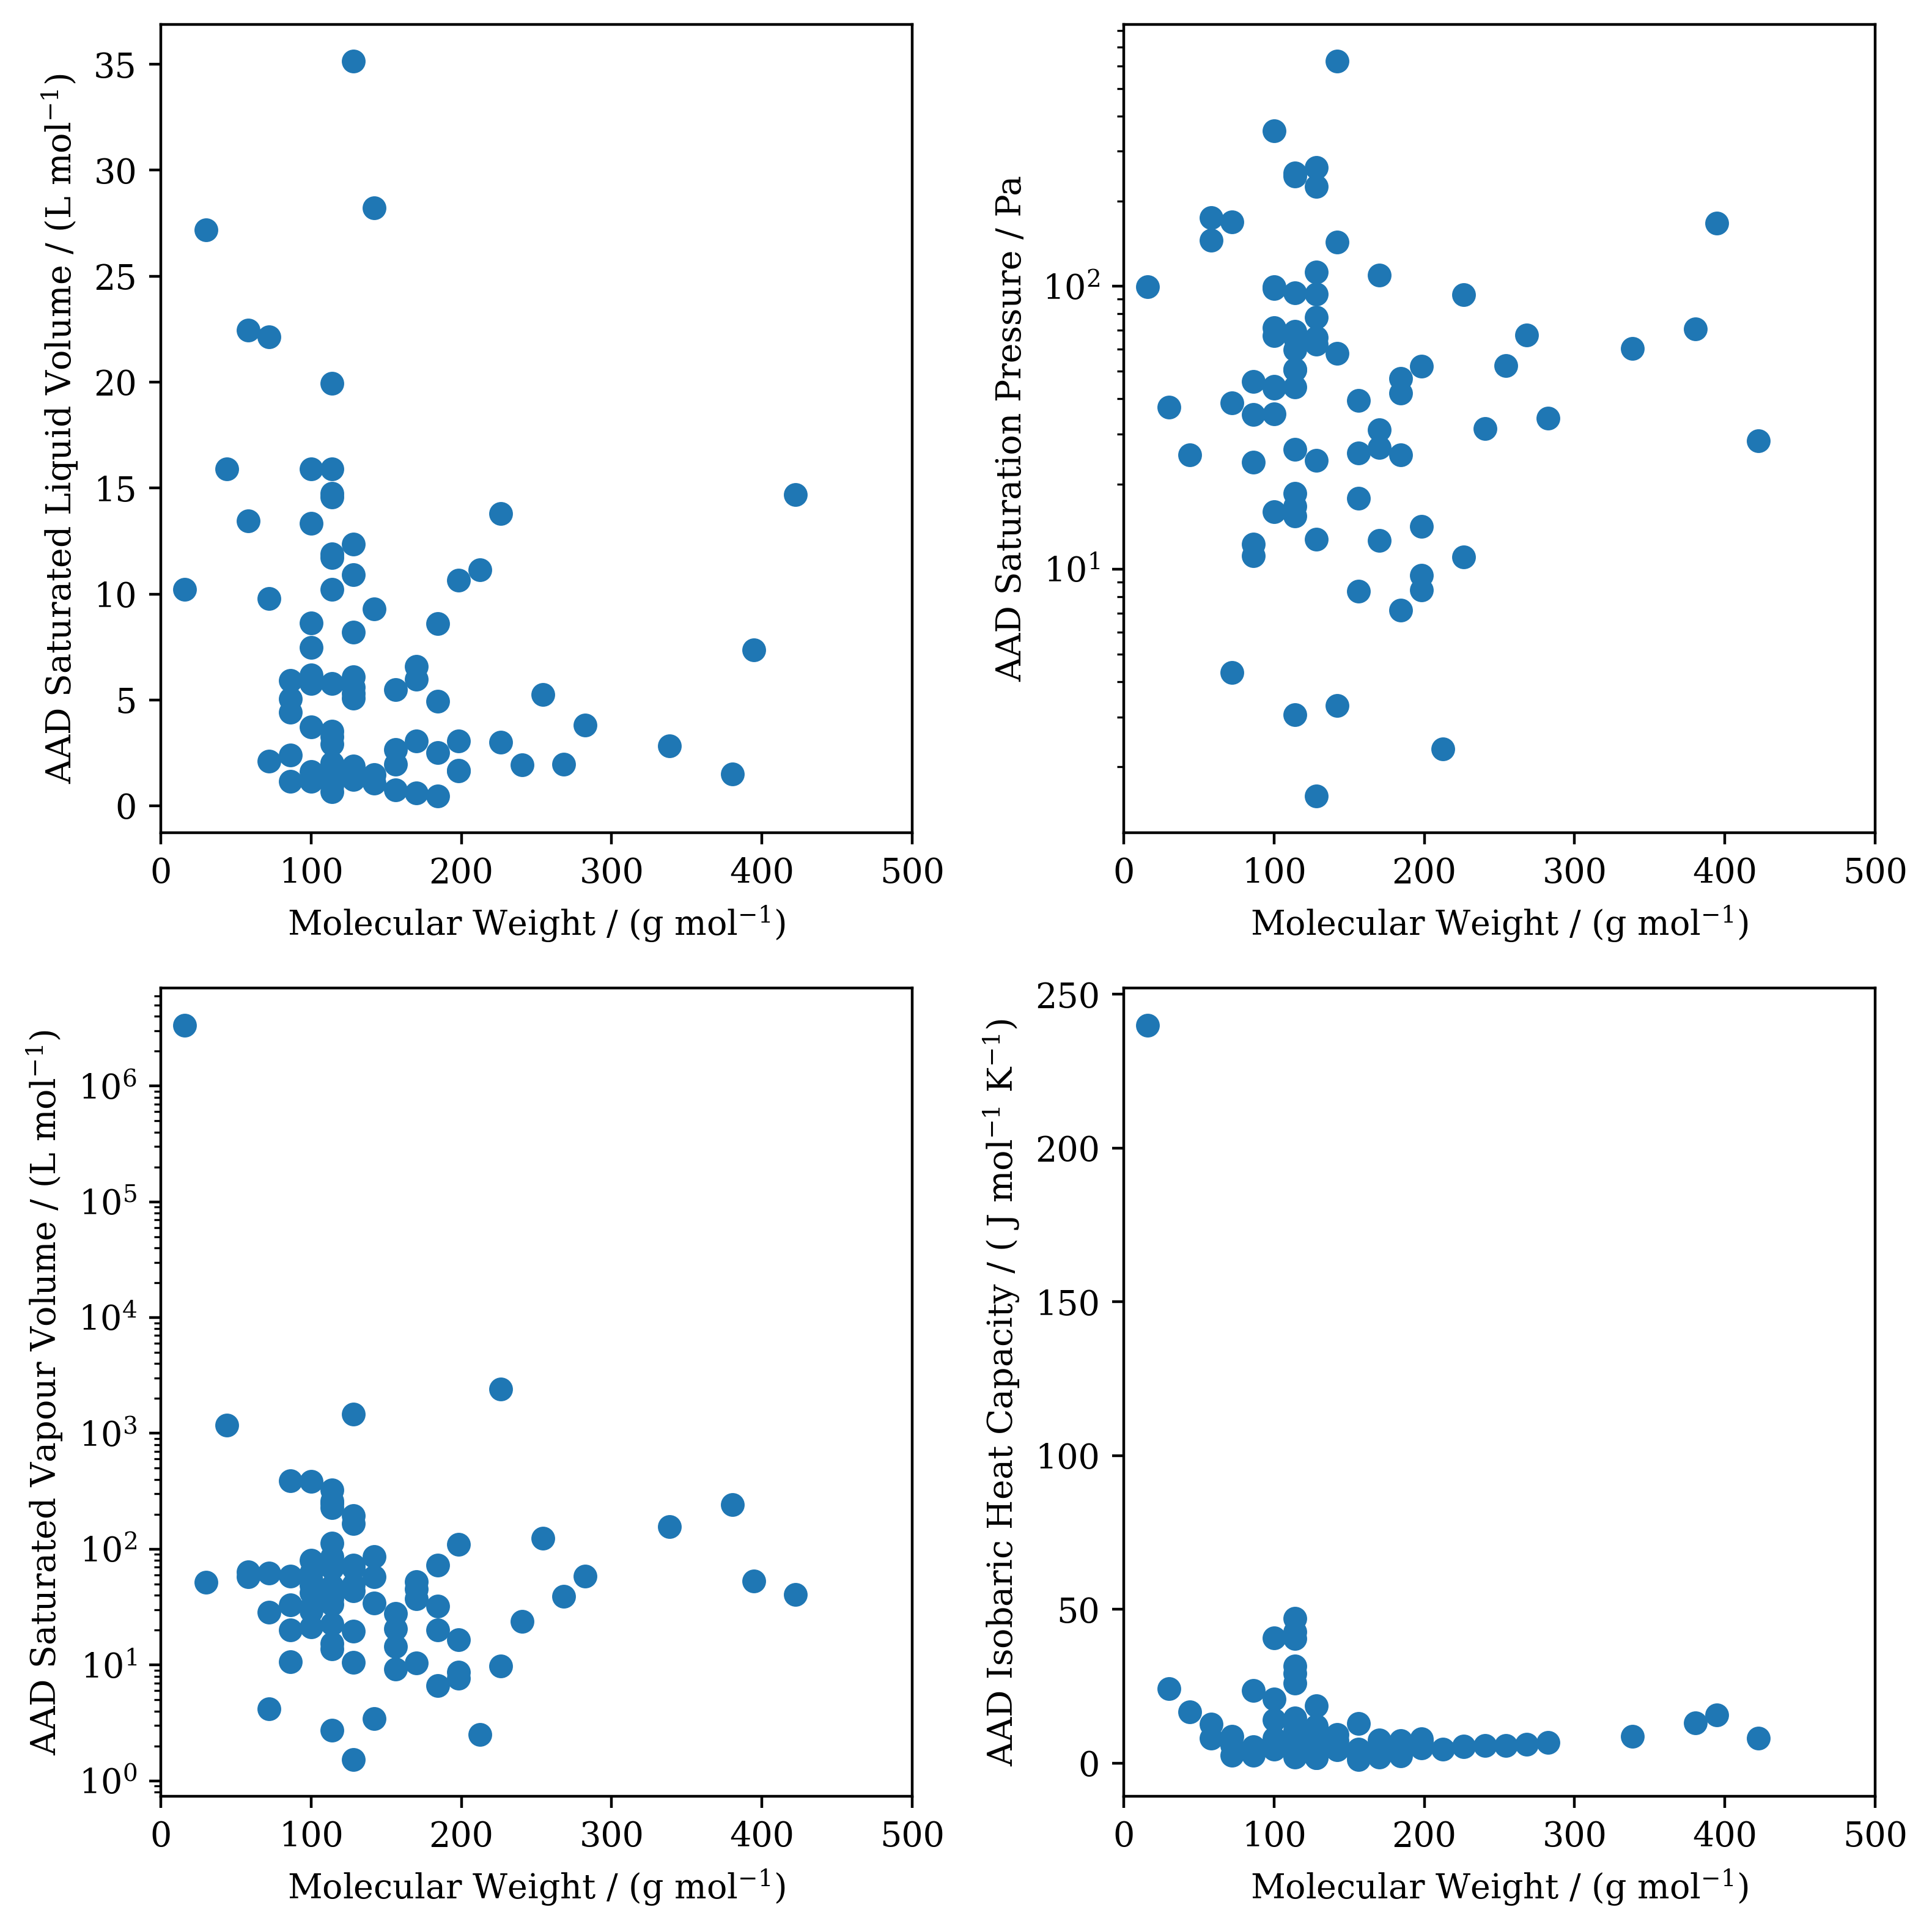

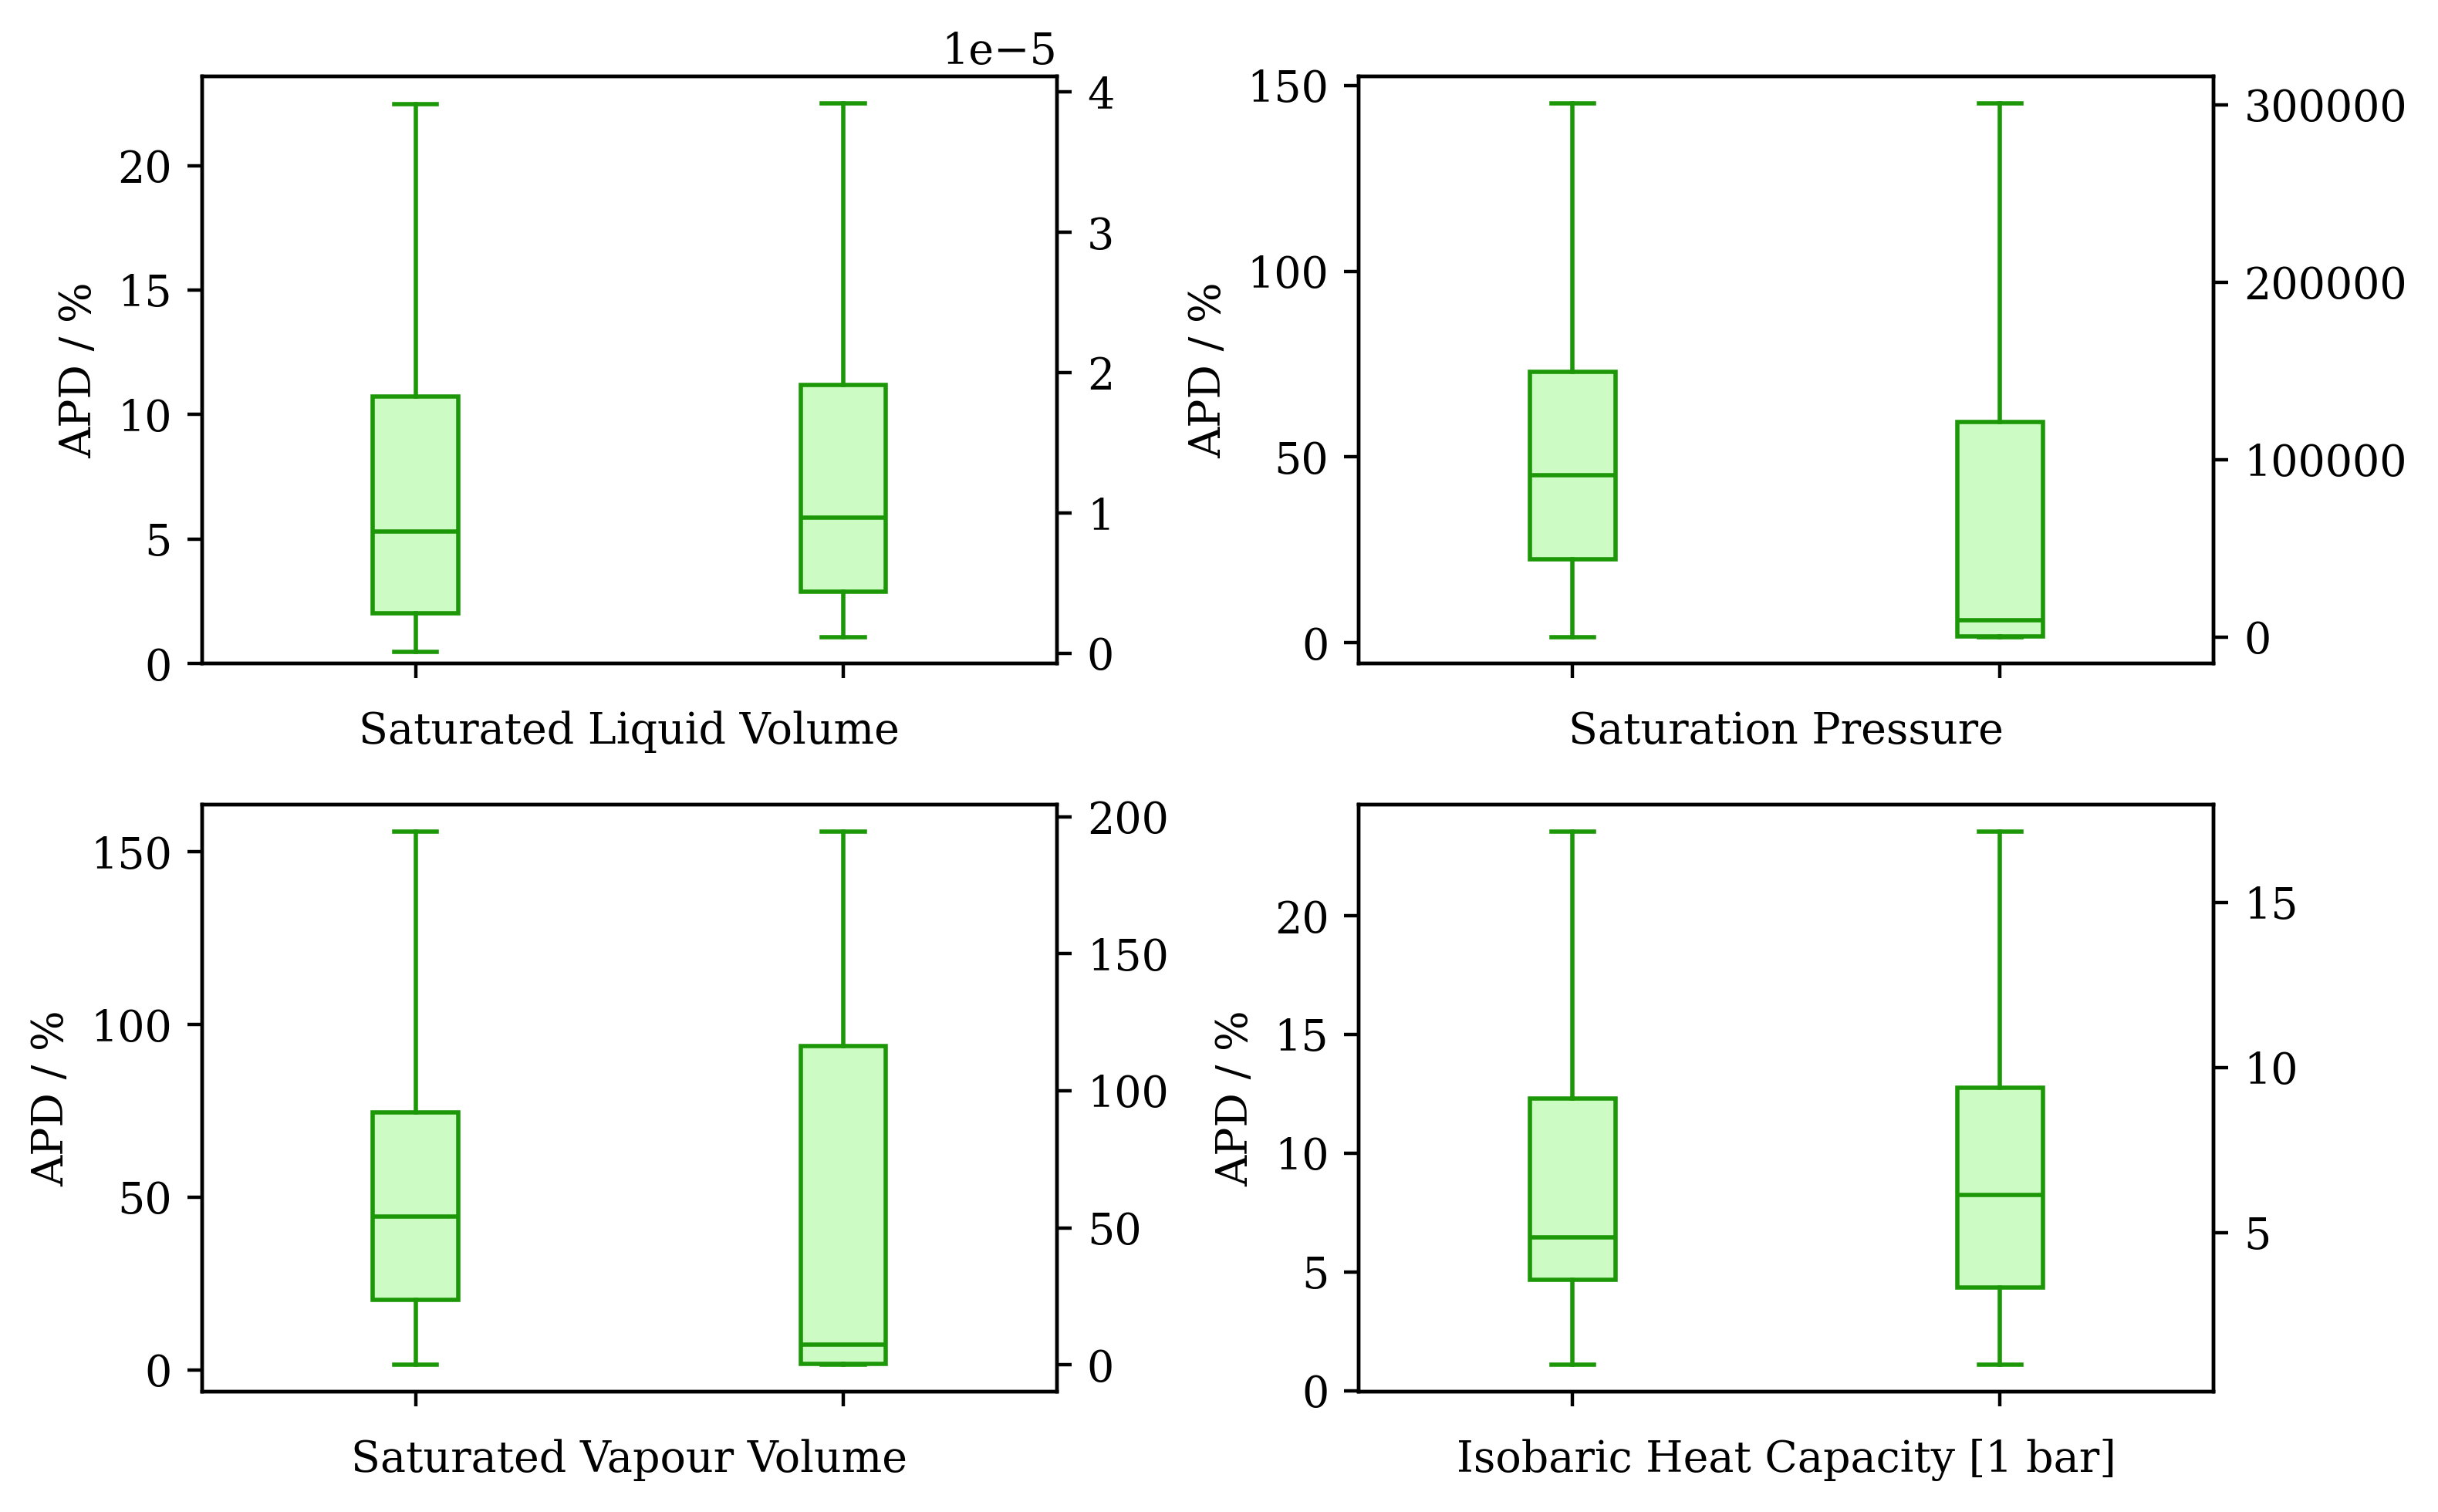

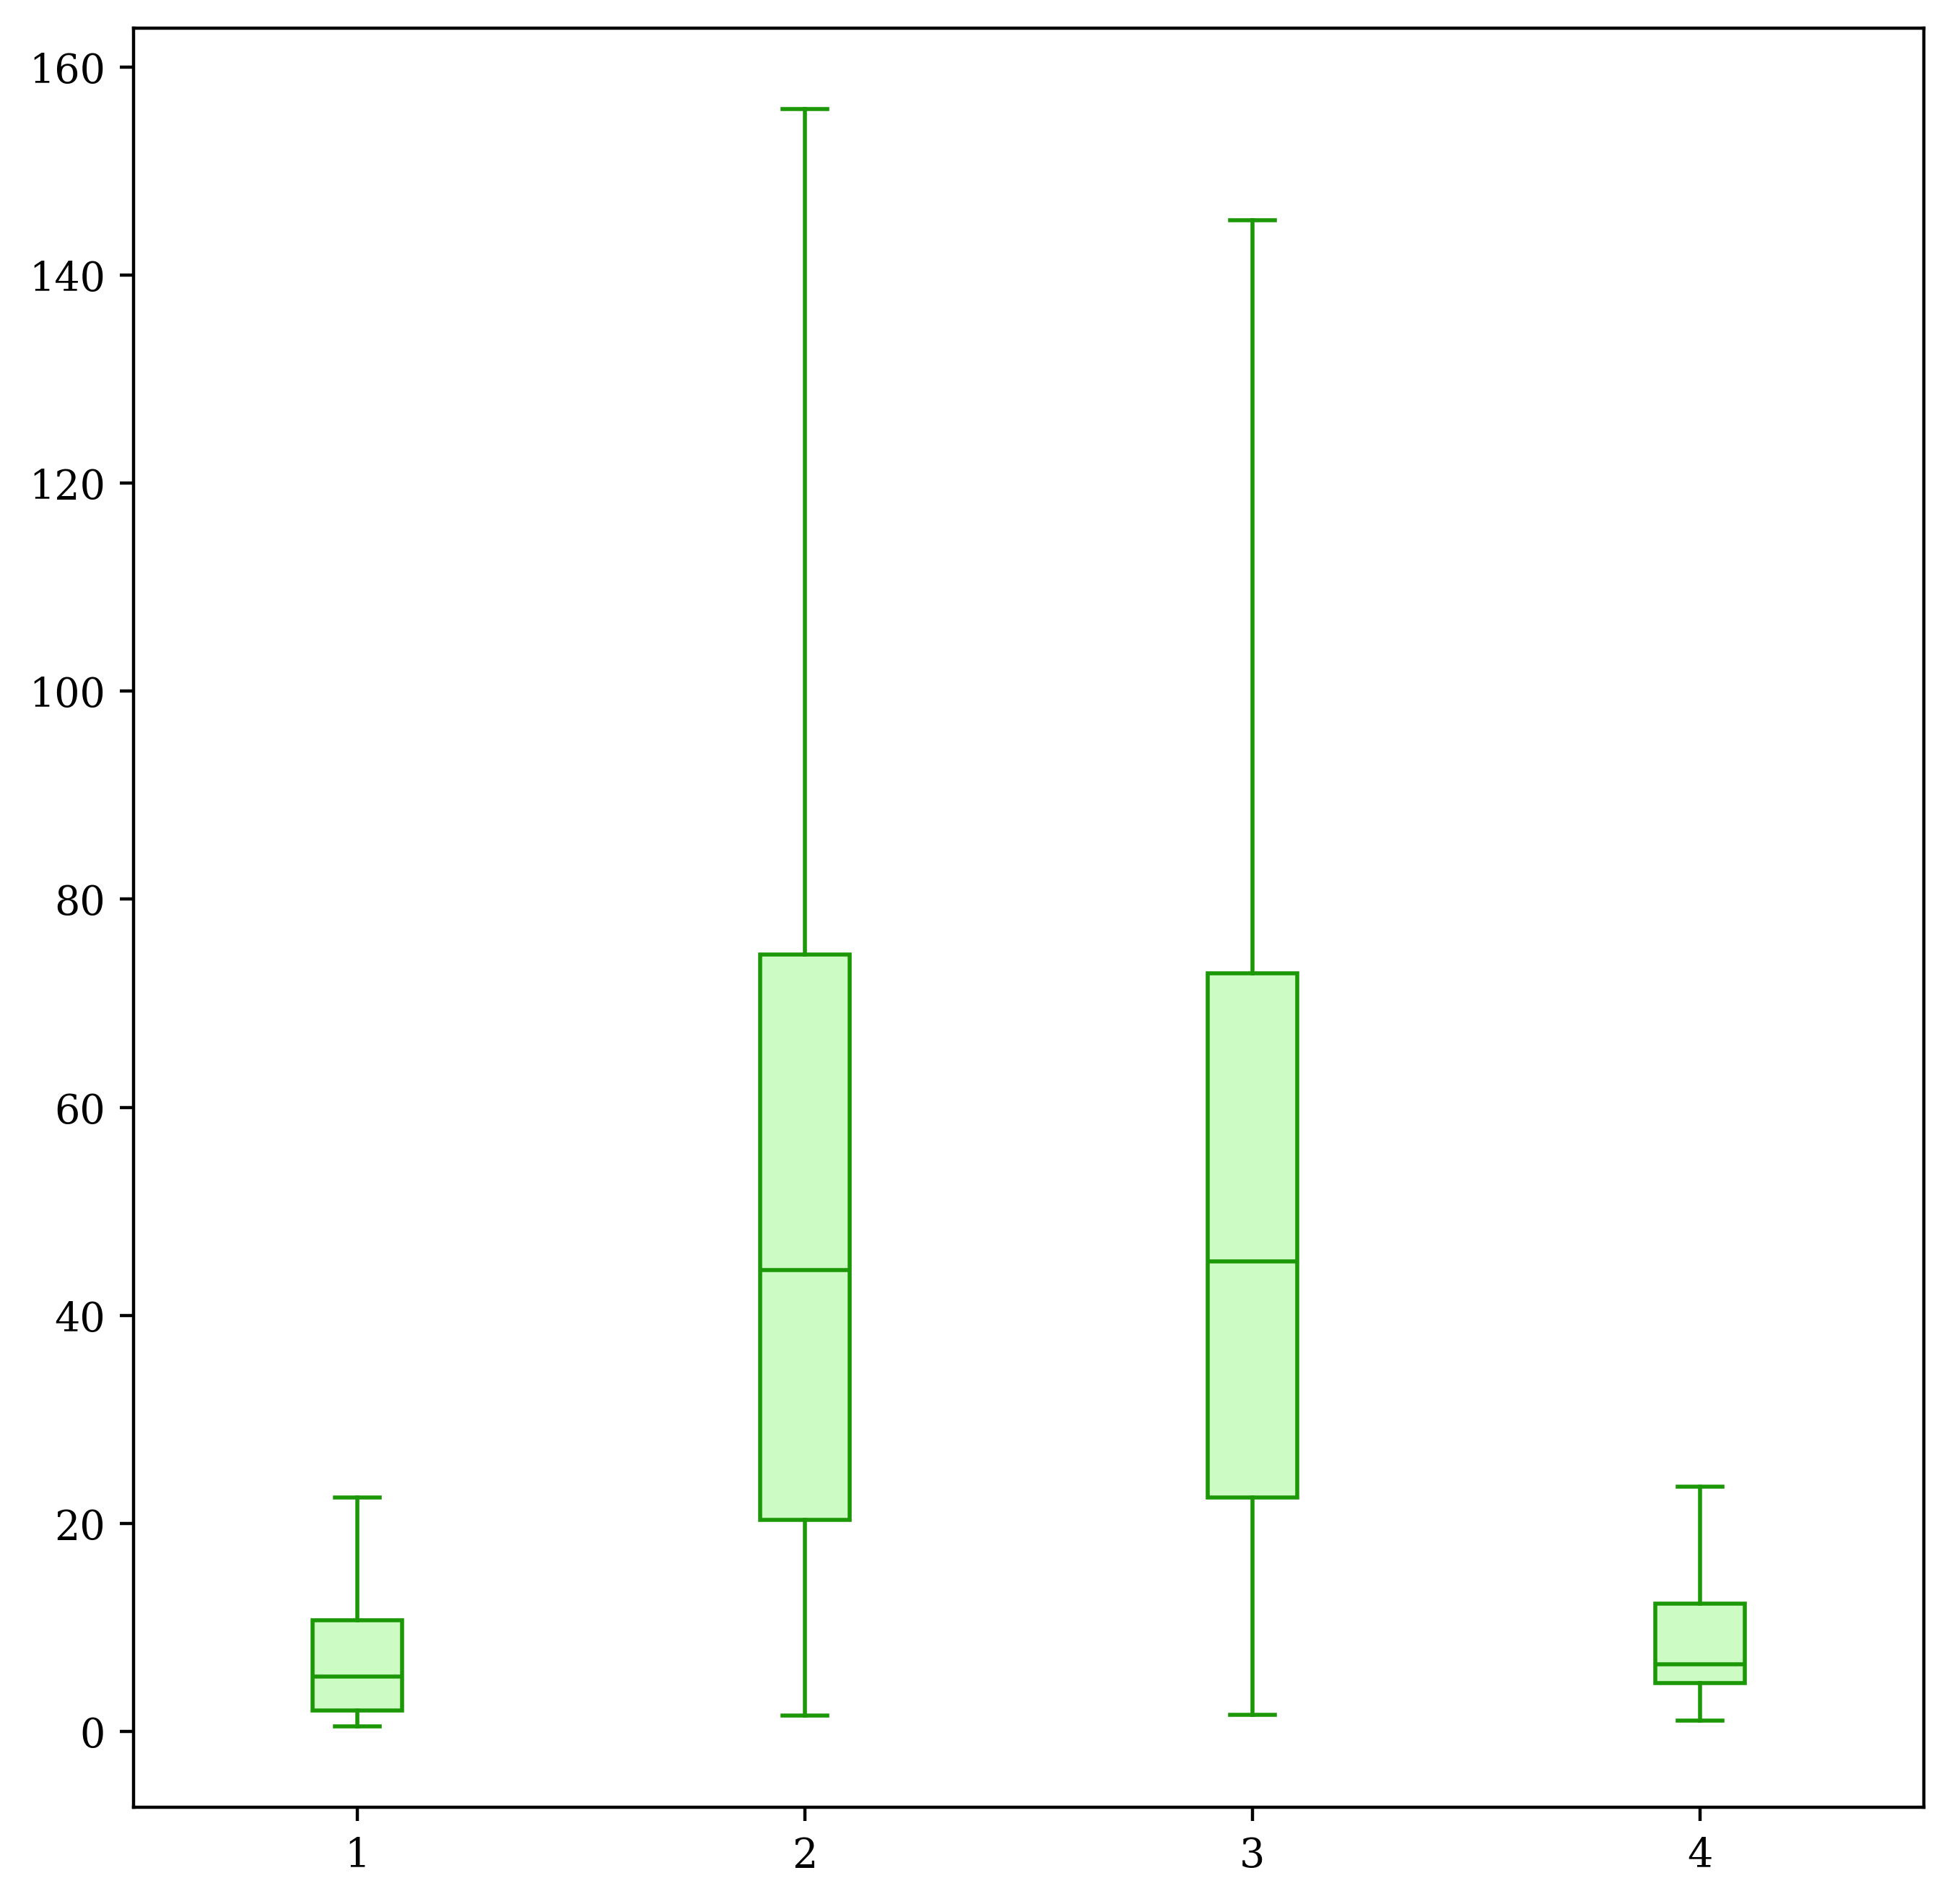

In [68]:
figure_1, axes_1 = plt.subplots(2,2, figsize=(8, 8), dpi=400)
figure_2, axes_2 = plt.subplots(2,2, figsize=(8, 5), dpi=400)
figure_3, axes_3 = plt.subplots(figsize=(8, 8), dpi=400)

matplotlib.font_manager[:findfont]("DejaVu Serif") !== nothing || PyCall.pyimport_conda("matplotlib", "matplotlib", "conda-forge")
rc("font", family="DejaVu Serif",size=10)

axes_1[1].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_vsat_l)
axes_1[2].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_vsat_v)
axes_1[3].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_psat)
axes_1[4].scatter(val_data_summary_APD.Mw, val_data_summary_APD.APD_cp)

axes_1[1].set_ylabel(L"AAD Saturated Liquid Volume / (L mol$\mathregular{^{-1}}$)")
axes_1[1].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[1].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[1].set_xlim([0, 500])

axes_1[2].set_ylabel(L"AAD Saturated Vapour Volume / (L mol$\mathregular{^{-1}}$)")
axes_1[2].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[2].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[2].set_xlim([0, 500])
axes_1[2].set_yscale("log")

axes_1[3].set_ylabel("AAD Saturation Pressure / Pa")
axes_1[3].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[3].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[3].set_xlim([0, 500])
axes_1[3].set_yscale("log")

axes_1[4].set_ylabel(L"AAD Isobaric Heat Capacity / ( J mol$\mathregular{^{-1}}$ K$\mathregular{^{-1}}$)")
axes_1[4].set_xlabel(L"Molecular Weight / (g mol$\mathregular{^{-1}}$)")
axes_1[4].set_xticks([0, 100, 200, 300, 400, 500])
axes_1[4].set_xlim([0, 500])



# Create a box plot with custom color and width
boxprops = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")  # Add facecolor for box fill
whiskerprops = Dict("linewidth" => 1, "color" => "#1C9707")
capprops = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none","markeredgecolor" => "#1C9707")
medianprops = Dict("color" => "#1C9707")
box_width = 0.2
showfliers=false

axes_2_1_2 = axes_2[1].twinx()
axes_2[1].boxplot(val_data_summary_APD[:, 4], positions=[1], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)
axes_2_1_2.boxplot(val_data_summary_AAD[:, 4], positions=[2], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)

axes_2_2_2 = axes_2[2].twinx()
axes_2[2].boxplot(val_data_summary_APD[:, 5], positions=[1], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)
axes_2_2_2.boxplot(val_data_summary_AAD[:, 5], positions=[2], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)

axes_2_3_2 = axes_2[3].twinx()
axes_2[3].boxplot(val_data_summary_APD[:, 6], positions=[1], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)
axes_2_3_2.boxplot(val_data_summary_AAD[:, 6], positions=[2], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)

axes_2_4_2 = axes_2[4].twinx()
axes_2[4].boxplot(val_data_summary_APD[:, 7], positions=[1], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)
axes_2_4_2.boxplot(val_data_summary_AAD[:, 7], positions=[2], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width,showfliers=showfliers)

axes_2[1].set_xlabel("Saturated Liquid Volume")
axes_2[1].set_ylabel("APD / %")
axes_2[1].set_xticklabels("")
axes_2[1].set_ylim([0, nothing])

# Set x-ticks for both box plots
axes1.set_xticks([1, 2])
axes1.set_xticklabels(["X Tick 1", "X Tick 2"])

axes_2[2].set_xlabel("Saturated Vapour Volume")
axes_2[2].set_ylabel("APD / %")
axes_2[2].set_xticklabels("")

axes_2[3].set_xlabel("Saturation Pressure")
axes_2[3].set_ylabel("APD / %")
axes_2[3].set_xticklabels("")

axes_2[4].set_xlabel("Isobaric Heat Capacity [1 bar]")
axes_2[4].set_ylabel("APD / %")
axes_2[4].set_xticklabels("")

box_data_grouped = [val_data_summary_APD[!, i] for i in [4,5,6,7]]#]:ncol(val_data_summary)]

axes_3.boxplot(box_data_grouped, boxprops=boxprops, showfliers=false,whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)

# axes_2.set_xticklabels(["Saturated Liquid Volume","Saturated Vapour Volume","Saturation Pressure","Isobaric Heat Capacity"],rotation=45)
# axes_2.set_ylabel("Average Percentage Deviation",fontsize=18)

# plt.xticks(fontsize=14, fontname="serif",rotation=40, ha="right")
# plt.yticks(fontsize=14, fontname="serif")
# plt.ylim([0,nothing])
# # axes_2.set_title

figure_1.tight_layout()
figure_2.tight_layout()

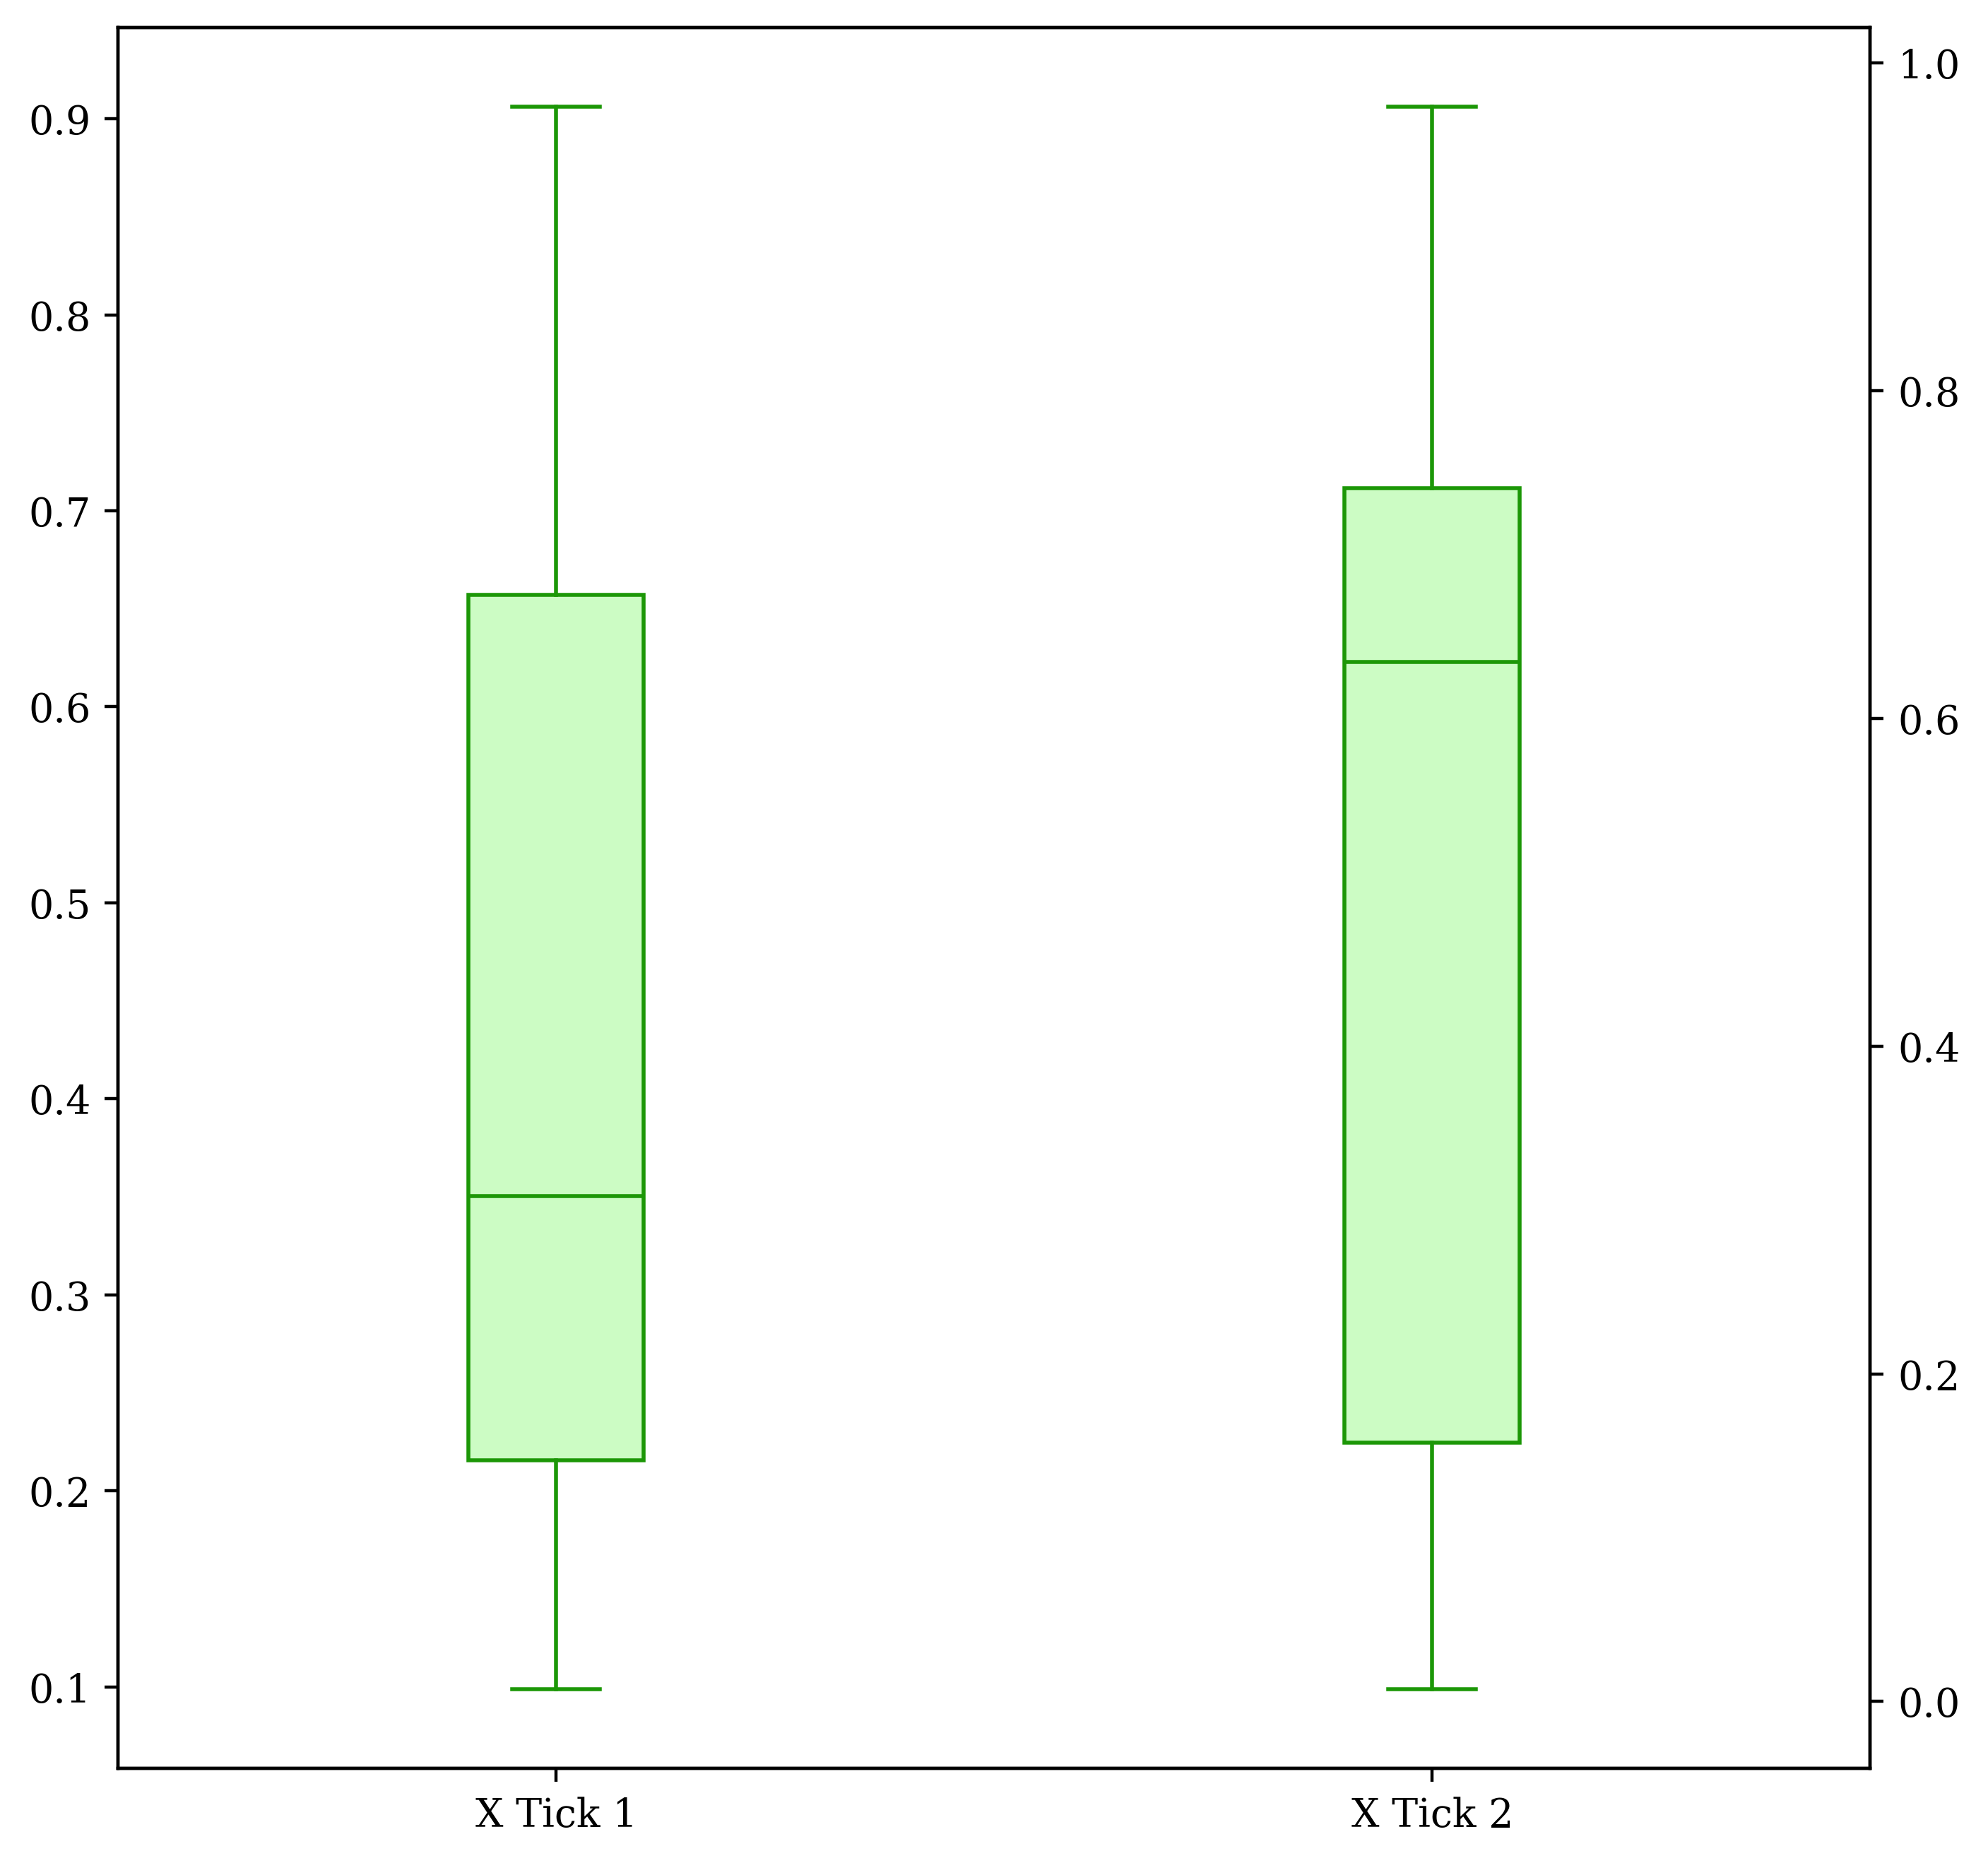

In [57]:
using PyPlot

# Sample data
val_data_summary = rand(10, 7)  # Adjust the size based on your data

# Create a subplot
figure1, axes1 = plt.subplots(figsize=(8, 8), dpi=400)

# Box plots on the left y-axis with different x-ticks
box_width = 0.2
boxprops = Dict("linewidth" => 1, "color" => "#1C9707", "facecolor" => "#CCFCC4")
whiskerprops = Dict("linewidth" => 1, "color" => "#1C9707")
capprops = Dict("linewidth" => 1, "color" => "#1C9707")
flierprops = Dict("markerfacecolor" => "#CCFCC4", "marker" => "o", "markersize" => 8, "linestyle" => "none", "markeredgecolor" => "#1C9707")
medianprops = Dict("color" => "#1C9707")

axes1.boxplot(val_data_summary[:, 4], positions=[1], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)

# Set labels, ticks, and limits for the left y-axis

# ...

# Create a twin Axes for the right y-axis
axes_2 = axes1.twinx()

# Box plot on the right y-axis with different x-ticks
axes_2.boxplot(val_data_summary[:, 5], positions=[2], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, medianprops=medianprops, patch_artist=true, widths=box_width)

# Set labels, ticks, and limits for the right y-axis

# ...

# Set x-ticks for both box plots
axes1.set_xticks([1, 2])
axes1.set_xticklabels(["X Tick 1", "X Tick 2"])

# Display the plot
show()
